# GAN example

In [1]:
# import necessary packages

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import sklearn

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, UpSampling2D, Embedding, Concatenate


In [8]:
noise_dim = 100 

In [2]:
import cv2
import os
import numpy as np
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        print("class",the_class)
        for file in os.listdir(indir+'/'+class_dir):
            #print(file)
            #print("{}/{}/{}".format(indir,class_dir,file))
            if file.endswith('ppm'):
                image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
                image = cv2.resize(image, (32,32))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = np.expand_dims(image,axis=2)
                samples.append(image)
                labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels

In [3]:
samples, labels = load_img('signs4')
print('loaded',len(samples),' samples')
print('classes',set(labels))
samples = samples/255

import sklearn.preprocessing
encoder = sklearn.preprocessing.LabelEncoder() # encoder
labels = encoder.fit_transform(labels)

class 00001
class 00007
class 00014
class 00016
loaded 3300  samples
classes {'00016', '00001', '00007', '00014'}


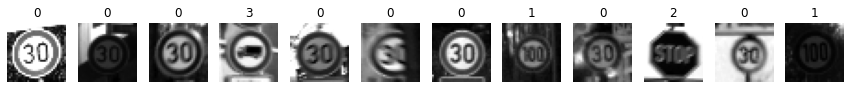

In [6]:
import random
plt.figure(figsize=(15, 15))
for i in range(12):
    ax = plt.subplot(1, 12, i + 1)
    r = random.randint(0,samples.shape[0])
    plt.imshow(samples[r][:,:,0],cmap='gray')
    plt.title(labels[r])
    plt.axis("off")

In [9]:
# Generator gets a noise vector of size noise_dim and class to generate (one of 0,1,2,3) and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible
def make_generator_model():
    
    
    input_layer = tf.keras.layers.Input(shape=(noise_dim,))
    x = Dense(8*8*256, use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 256))(x)

    
    # second input - gets a class (vector of 4 values) 
    input_label = tf.keras.layers.Input(shape=(1,))
    # embedding from 4 values to 50
    y = Embedding(4, 50)(input_label)
    # scale up to 8*8 to fit the first input
    y = Dense(8*8)(y)
    y = Reshape((8, 8, 1))(y)
 
    # join both inputs
    merged = Concatenate()([x, y])
 
    
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)(merged)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # output: 8 x 8 x 128

    x = UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # output: 16 x 16 x 64

    x = UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    output_layer = Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')(x)
    # output: 32 x 32 x 1 (our image)

    model = tf.keras.models.Model(inputs=[input_layer,input_label], outputs=output_layer)
    model.summary()
    return model



generator = make_generator_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        1638400     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16384)        65536       dense[0][0]                      
______________________________________________________________________________________________

In [10]:
# Discriminator gets image of size (32 x 32 x 1) and class (one of 0,1,2,3) and decides if the image is real or fake
def make_discriminator_model():
    
    
    # input 1 - one number, class id (0,1,2,3)
    input_label = tf.keras.layers.Input(shape=(1,))
    # embedding from 4 values to 50
    y = Embedding(4, 50)(input_label)
    # scale up to image dimensions with linear activation
    y = Dense(32*32)(y)
    y = Reshape((32, 32, 1))(y)
 
    
    # input 2 - the image
    input_layer = tf.keras.layers.Input(shape=(32, 32, 1))
    
    # image (32x32x1) is concatenated with the class (encoded as 32x32x1) so the result is 32x32x2
    merged = Concatenate()([input_layer, y])
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1])(merged)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    output_layer = Dense(1,activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[input_layer,input_label], outputs=output_layer)
    # output: one number 0-fake, 1-real
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        200         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 1024)      52224       embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32, 32, 1)]  0                                            
____________________________________________________________________________________________

In [11]:
# returns randomly choosen n samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    new_labels = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
        new_labels.append(labels[number])
    new_samples = np.array(new_samples,dtype=float)    
    new_labels = np.array(new_labels)    
    return new_samples,new_labels

In [12]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [13]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step

history = []
##@tf.function
def do_step(images, labels):
    batch_size = len(images)
    images = np.array(images)
    labels = np.expand_dims(labels,axis=1)
    # create a random noise for generator
    input_noise = tf.random.normal([batch_size, noise_dim])

    random_labels = np.random.randint(4, size=batch_size)
    random_labels = np.expand_dims(random_labels,axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator([input_noise,random_labels], training=True)
        # evaluate fake images
        fake_output = discriminator([generated_images,random_labels], training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator want all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator([images,labels], training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print("Epoch",epoch,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

Epoch 0 g_loss= 0.71385026 d_loss= 0.6895455 real_acc= 0.24 fake_acc= 0.8


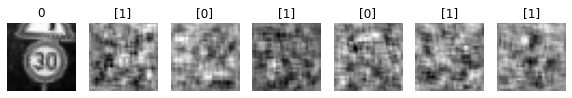

Epoch 1 g_loss= 0.7252047 d_loss= 0.690613 real_acc= 0.08 fake_acc= 0.94
Epoch 2 g_loss= 0.7417762 d_loss= 0.6867751 real_acc= 0.02 fake_acc= 1.0
Epoch 3 g_loss= 0.7679909 d_loss= 0.6898144 real_acc= 0.0 fake_acc= 1.0
Epoch 4 g_loss= 0.7823757 d_loss= 0.6884615 real_acc= 0.0 fake_acc= 1.0
Epoch 5 g_loss= 0.79837245 d_loss= 0.68302 real_acc= 0.0 fake_acc= 1.0
Epoch 6 g_loss= 0.80711806 d_loss= 0.696741 real_acc= 0.0 fake_acc= 1.0
Epoch 7 g_loss= 0.8005406 d_loss= 0.68703556 real_acc= 0.0 fake_acc= 1.0
Epoch 8 g_loss= 0.8096724 d_loss= 0.68469846 real_acc= 0.0 fake_acc= 1.0
Epoch 9 g_loss= 0.8124498 d_loss= 0.68432236 real_acc= 0.0 fake_acc= 1.0
Epoch 10 g_loss= 0.8101841 d_loss= 0.6854806 real_acc= 0.0 fake_acc= 1.0


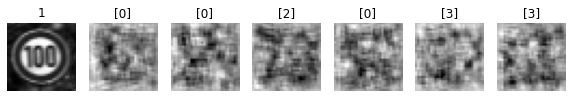

Epoch 11 g_loss= 0.8109461 d_loss= 0.6768446 real_acc= 0.0 fake_acc= 1.0
Epoch 12 g_loss= 0.8121186 d_loss= 0.68665165 real_acc= 0.02 fake_acc= 1.0
Epoch 13 g_loss= 0.8023485 d_loss= 0.68870676 real_acc= 0.08 fake_acc= 1.0
Epoch 14 g_loss= 0.7994006 d_loss= 0.68296415 real_acc= 0.06 fake_acc= 1.0
Epoch 15 g_loss= 0.7922612 d_loss= 0.6793437 real_acc= 0.14 fake_acc= 1.0
Epoch 16 g_loss= 0.77673095 d_loss= 0.68280375 real_acc= 0.16 fake_acc= 1.0
Epoch 17 g_loss= 0.75808525 d_loss= 0.6873865 real_acc= 0.16 fake_acc= 1.0
Epoch 18 g_loss= 0.7495781 d_loss= 0.6842947 real_acc= 0.32 fake_acc= 0.98
Epoch 19 g_loss= 0.7387442 d_loss= 0.69493496 real_acc= 0.34 fake_acc= 0.92
Epoch 20 g_loss= 0.72006726 d_loss= 0.7023785 real_acc= 0.32 fake_acc= 0.9


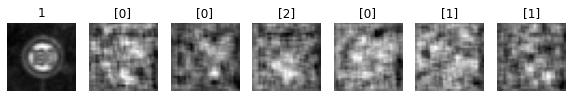

Epoch 21 g_loss= 0.70353013 d_loss= 0.7122851 real_acc= 0.24 fake_acc= 0.66
Epoch 22 g_loss= 0.69173425 d_loss= 0.7032613 real_acc= 0.46 fake_acc= 0.48
Epoch 23 g_loss= 0.67736894 d_loss= 0.7068007 real_acc= 0.52 fake_acc= 0.24
Epoch 24 g_loss= 0.66598785 d_loss= 0.7085999 real_acc= 0.54 fake_acc= 0.14
Epoch 25 g_loss= 0.66231894 d_loss= 0.70682365 real_acc= 0.62 fake_acc= 0.08
Epoch 26 g_loss= 0.6513568 d_loss= 0.712038 real_acc= 0.64 fake_acc= 0.04
Epoch 27 g_loss= 0.65205294 d_loss= 0.7153292 real_acc= 0.56 fake_acc= 0.08
Epoch 28 g_loss= 0.64404404 d_loss= 0.7184987 real_acc= 0.6 fake_acc= 0.0
Epoch 29 g_loss= 0.65208405 d_loss= 0.7135731 real_acc= 0.54 fake_acc= 0.04
Epoch 30 g_loss= 0.6521927 d_loss= 0.70997036 real_acc= 0.66 fake_acc= 0.04


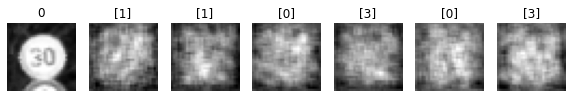

Epoch 31 g_loss= 0.6623575 d_loss= 0.7006708 real_acc= 0.84 fake_acc= 0.12
Epoch 32 g_loss= 0.6751982 d_loss= 0.6974102 real_acc= 0.7 fake_acc= 0.22
Epoch 33 g_loss= 0.68981516 d_loss= 0.69175756 real_acc= 0.62 fake_acc= 0.4
Epoch 34 g_loss= 0.695669 d_loss= 0.6889594 real_acc= 0.68 fake_acc= 0.62
Epoch 35 g_loss= 0.712585 d_loss= 0.68586034 real_acc= 0.52 fake_acc= 0.74
Epoch 36 g_loss= 0.73327875 d_loss= 0.6822751 real_acc= 0.4 fake_acc= 0.86
Epoch 37 g_loss= 0.74498296 d_loss= 0.6722605 real_acc= 0.46 fake_acc= 1.0
Epoch 38 g_loss= 0.7686072 d_loss= 0.6639744 real_acc= 0.44 fake_acc= 0.98
Epoch 39 g_loss= 0.7755279 d_loss= 0.66488713 real_acc= 0.26 fake_acc= 1.0
Epoch 40 g_loss= 0.7954707 d_loss= 0.65356237 real_acc= 0.42 fake_acc= 1.0


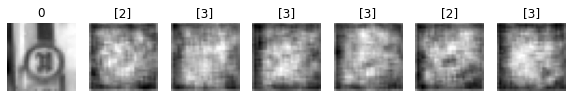

Epoch 41 g_loss= 0.81511796 d_loss= 0.65174794 real_acc= 0.26 fake_acc= 1.0
Epoch 42 g_loss= 0.8191394 d_loss= 0.6535368 real_acc= 0.36 fake_acc= 1.0
Epoch 43 g_loss= 0.8256564 d_loss= 0.6436548 real_acc= 0.24 fake_acc= 1.0
Epoch 44 g_loss= 0.8363724 d_loss= 0.6513947 real_acc= 0.26 fake_acc= 1.0
Epoch 45 g_loss= 0.832793 d_loss= 0.64352286 real_acc= 0.34 fake_acc= 1.0
Epoch 46 g_loss= 0.8309999 d_loss= 0.66169393 real_acc= 0.18 fake_acc= 1.0
Epoch 47 g_loss= 0.8202065 d_loss= 0.6696179 real_acc= 0.18 fake_acc= 1.0
Epoch 48 g_loss= 0.81074846 d_loss= 0.6597871 real_acc= 0.28 fake_acc= 1.0
Epoch 49 g_loss= 0.78834474 d_loss= 0.6819587 real_acc= 0.22 fake_acc= 0.96
Epoch 50 g_loss= 0.7738522 d_loss= 0.69425845 real_acc= 0.26 fake_acc= 0.98


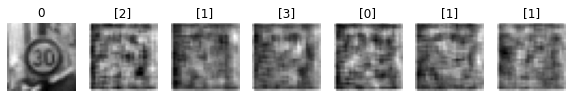

Epoch 51 g_loss= 0.751292 d_loss= 0.70690405 real_acc= 0.24 fake_acc= 0.9
Epoch 52 g_loss= 0.72608757 d_loss= 0.7046236 real_acc= 0.2 fake_acc= 0.76
Epoch 53 g_loss= 0.7010677 d_loss= 0.72798645 real_acc= 0.14 fake_acc= 0.62
Epoch 54 g_loss= 0.6838828 d_loss= 0.74437505 real_acc= 0.2 fake_acc= 0.48
Epoch 55 g_loss= 0.6518279 d_loss= 0.7589886 real_acc= 0.18 fake_acc= 0.16
Epoch 56 g_loss= 0.63755274 d_loss= 0.7555622 real_acc= 0.2 fake_acc= 0.1
Epoch 57 g_loss= 0.61358106 d_loss= 0.7668741 real_acc= 0.32 fake_acc= 0.0
Epoch 58 g_loss= 0.6063698 d_loss= 0.78313977 real_acc= 0.12 fake_acc= 0.0
Epoch 59 g_loss= 0.59176844 d_loss= 0.7815392 real_acc= 0.24 fake_acc= 0.0
Epoch 60 g_loss= 0.59284914 d_loss= 0.77975345 real_acc= 0.28 fake_acc= 0.0


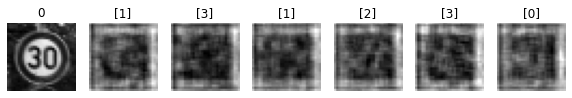

Epoch 61 g_loss= 0.5831646 d_loss= 0.7894879 real_acc= 0.28 fake_acc= 0.0
Epoch 62 g_loss= 0.5817682 d_loss= 0.7767142 real_acc= 0.34 fake_acc= 0.0
Epoch 63 g_loss= 0.58643997 d_loss= 0.77441204 real_acc= 0.34 fake_acc= 0.0
Epoch 64 g_loss= 0.58518606 d_loss= 0.78210235 real_acc= 0.24 fake_acc= 0.0
Epoch 65 g_loss= 0.5909166 d_loss= 0.7666799 real_acc= 0.28 fake_acc= 0.0
Epoch 66 g_loss= 0.6026617 d_loss= 0.74852216 real_acc= 0.48 fake_acc= 0.0
Epoch 67 g_loss= 0.60744804 d_loss= 0.7404214 real_acc= 0.46 fake_acc= 0.0
Epoch 68 g_loss= 0.6243385 d_loss= 0.7296323 real_acc= 0.52 fake_acc= 0.0
Epoch 69 g_loss= 0.6322304 d_loss= 0.7366745 real_acc= 0.52 fake_acc= 0.02
Epoch 70 g_loss= 0.6428516 d_loss= 0.71815217 real_acc= 0.6 fake_acc= 0.02


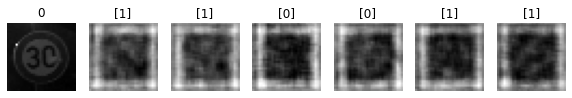

Epoch 71 g_loss= 0.65876013 d_loss= 0.71282846 real_acc= 0.58 fake_acc= 0.08
Epoch 72 g_loss= 0.67376536 d_loss= 0.69842136 real_acc= 0.68 fake_acc= 0.2
Epoch 73 g_loss= 0.691716 d_loss= 0.6925172 real_acc= 0.64 fake_acc= 0.42
Epoch 74 g_loss= 0.7076783 d_loss= 0.6862613 real_acc= 0.6 fake_acc= 0.7
Epoch 75 g_loss= 0.7211318 d_loss= 0.68143684 real_acc= 0.5 fake_acc= 0.84
Epoch 76 g_loss= 0.7374451 d_loss= 0.6772146 real_acc= 0.46 fake_acc= 0.98
Epoch 77 g_loss= 0.7531922 d_loss= 0.66207856 real_acc= 0.66 fake_acc= 0.98
Epoch 78 g_loss= 0.7631529 d_loss= 0.6580123 real_acc= 0.62 fake_acc= 0.98
Epoch 79 g_loss= 0.7786876 d_loss= 0.65308416 real_acc= 0.66 fake_acc= 0.96
Epoch 80 g_loss= 0.7836018 d_loss= 0.6503545 real_acc= 0.68 fake_acc= 0.98


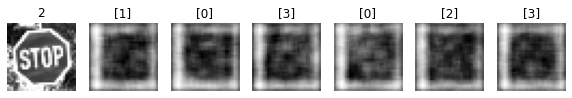

Epoch 81 g_loss= 0.78268784 d_loss= 0.6569202 real_acc= 0.48 fake_acc= 0.98
Epoch 82 g_loss= 0.78620005 d_loss= 0.65493476 real_acc= 0.56 fake_acc= 0.98
Epoch 83 g_loss= 0.78011537 d_loss= 0.64924204 real_acc= 0.7 fake_acc= 1.0
Epoch 84 g_loss= 0.7790155 d_loss= 0.6539494 real_acc= 0.66 fake_acc= 1.0
Epoch 85 g_loss= 0.78467375 d_loss= 0.6463055 real_acc= 0.72 fake_acc= 0.98
Epoch 86 g_loss= 0.77924085 d_loss= 0.6521392 real_acc= 0.72 fake_acc= 1.0
Epoch 87 g_loss= 0.7782643 d_loss= 0.6638217 real_acc= 0.46 fake_acc= 1.0
Epoch 88 g_loss= 0.7769425 d_loss= 0.6573124 real_acc= 0.64 fake_acc= 1.0
Epoch 89 g_loss= 0.77968335 d_loss= 0.64836144 real_acc= 0.6 fake_acc= 1.0
Epoch 90 g_loss= 0.7865367 d_loss= 0.6500716 real_acc= 0.62 fake_acc= 1.0


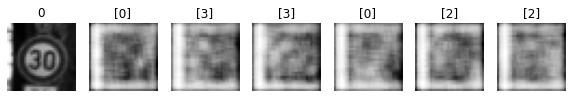

Epoch 91 g_loss= 0.78458166 d_loss= 0.63766766 real_acc= 0.66 fake_acc= 1.0
Epoch 92 g_loss= 0.78198504 d_loss= 0.6359706 real_acc= 0.68 fake_acc= 0.98
Epoch 93 g_loss= 0.7926165 d_loss= 0.6398381 real_acc= 0.72 fake_acc= 1.0
Epoch 94 g_loss= 0.7977907 d_loss= 0.6311815 real_acc= 0.72 fake_acc= 1.0
Epoch 95 g_loss= 0.80384946 d_loss= 0.6359657 real_acc= 0.7 fake_acc= 1.0
Epoch 96 g_loss= 0.8032312 d_loss= 0.61832464 real_acc= 0.78 fake_acc= 1.0
Epoch 97 g_loss= 0.81260026 d_loss= 0.61772525 real_acc= 0.76 fake_acc= 1.0
Epoch 98 g_loss= 0.81125313 d_loss= 0.6266694 real_acc= 0.72 fake_acc= 0.94
Epoch 99 g_loss= 0.81382036 d_loss= 0.61495095 real_acc= 0.82 fake_acc= 0.94
Epoch 100 g_loss= 0.795994 d_loss= 0.6356275 real_acc= 0.66 fake_acc= 0.94


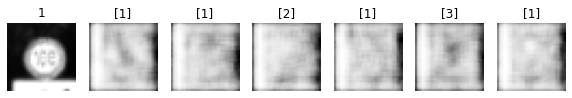

Epoch 101 g_loss= 0.78801566 d_loss= 0.6476616 real_acc= 0.66 fake_acc= 0.92
Epoch 102 g_loss= 0.77504104 d_loss= 0.62568593 real_acc= 0.8 fake_acc= 0.8
Epoch 103 g_loss= 0.78110975 d_loss= 0.63615394 real_acc= 0.66 fake_acc= 0.86
Epoch 104 g_loss= 0.76214355 d_loss= 0.6191181 real_acc= 0.9 fake_acc= 0.82
Epoch 105 g_loss= 0.7481588 d_loss= 0.63413084 real_acc= 0.86 fake_acc= 0.7
Epoch 106 g_loss= 0.725659 d_loss= 0.64216495 real_acc= 0.8 fake_acc= 0.66
Epoch 107 g_loss= 0.7133555 d_loss= 0.64800835 real_acc= 0.78 fake_acc= 0.58
Epoch 108 g_loss= 0.70561063 d_loss= 0.63426274 real_acc= 0.76 fake_acc= 0.52
Epoch 109 g_loss= 0.6932804 d_loss= 0.6558368 real_acc= 0.82 fake_acc= 0.5
Epoch 110 g_loss= 0.67386705 d_loss= 0.6485939 real_acc= 0.86 fake_acc= 0.36


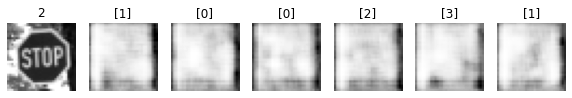

Epoch 111 g_loss= 0.6802546 d_loss= 0.6699712 real_acc= 0.7 fake_acc= 0.42
Epoch 112 g_loss= 0.6721001 d_loss= 0.6695172 real_acc= 0.78 fake_acc= 0.54
Epoch 113 g_loss= 0.6736627 d_loss= 0.6770046 real_acc= 0.76 fake_acc= 0.46
Epoch 114 g_loss= 0.6843645 d_loss= 0.6835704 real_acc= 0.8 fake_acc= 0.42
Epoch 115 g_loss= 0.68767333 d_loss= 0.69575465 real_acc= 0.64 fake_acc= 0.46
Epoch 116 g_loss= 0.7045982 d_loss= 0.68788755 real_acc= 0.62 fake_acc= 0.54
Epoch 117 g_loss= 0.75645775 d_loss= 0.6723162 real_acc= 0.6 fake_acc= 0.7
Epoch 118 g_loss= 0.7819094 d_loss= 0.66240716 real_acc= 0.58 fake_acc= 0.74
Epoch 119 g_loss= 0.8043207 d_loss= 0.7313894 real_acc= 0.42 fake_acc= 0.74
Epoch 120 g_loss= 0.8409612 d_loss= 0.7043358 real_acc= 0.28 fake_acc= 0.74


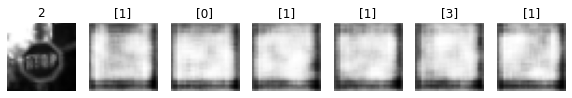

Epoch 121 g_loss= 0.9232922 d_loss= 0.68096983 real_acc= 0.26 fake_acc= 0.78
Epoch 122 g_loss= 0.91964203 d_loss= 0.70743704 real_acc= 0.2 fake_acc= 0.72
Epoch 123 g_loss= 0.92554367 d_loss= 0.72542477 real_acc= 0.12 fake_acc= 0.74
Epoch 124 g_loss= 1.013609 d_loss= 0.69786507 real_acc= 0.06 fake_acc= 0.82
Epoch 125 g_loss= 1.0159874 d_loss= 0.700954 real_acc= 0.06 fake_acc= 0.88
Epoch 126 g_loss= 0.99511236 d_loss= 0.6849075 real_acc= 0.1 fake_acc= 0.9
Epoch 127 g_loss= 1.0231901 d_loss= 0.6960139 real_acc= 0.06 fake_acc= 0.8
Epoch 128 g_loss= 1.0347359 d_loss= 0.6718933 real_acc= 0.1 fake_acc= 0.84
Epoch 129 g_loss= 1.0234265 d_loss= 0.6809099 real_acc= 0.12 fake_acc= 0.96
Epoch 130 g_loss= 1.033312 d_loss= 0.7004622 real_acc= 0.1 fake_acc= 0.92


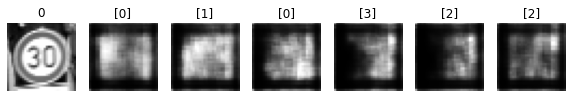

Epoch 131 g_loss= 1.012424 d_loss= 0.67477983 real_acc= 0.1 fake_acc= 0.98
Epoch 132 g_loss= 1.0060692 d_loss= 0.660808 real_acc= 0.1 fake_acc= 0.98
Epoch 133 g_loss= 0.960578 d_loss= 0.68741345 real_acc= 0.04 fake_acc= 0.96
Epoch 134 g_loss= 0.97699034 d_loss= 0.6524699 real_acc= 0.14 fake_acc= 0.94
Epoch 135 g_loss= 0.9425684 d_loss= 0.6504822 real_acc= 0.26 fake_acc= 1.0
Epoch 136 g_loss= 0.93399096 d_loss= 0.66832733 real_acc= 0.16 fake_acc= 0.92
Epoch 137 g_loss= 0.9474577 d_loss= 0.6488501 real_acc= 0.24 fake_acc= 0.92
Epoch 138 g_loss= 0.9271254 d_loss= 0.664954 real_acc= 0.18 fake_acc= 0.98
Epoch 139 g_loss= 0.8932345 d_loss= 0.69101965 real_acc= 0.16 fake_acc= 0.98
Epoch 140 g_loss= 0.9126598 d_loss= 0.6706526 real_acc= 0.12 fake_acc= 0.96


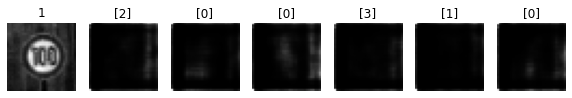

Epoch 141 g_loss= 0.867957 d_loss= 0.6816441 real_acc= 0.2 fake_acc= 0.94
Epoch 142 g_loss= 0.86518663 d_loss= 0.6882729 real_acc= 0.26 fake_acc= 0.94
Epoch 143 g_loss= 0.8659749 d_loss= 0.6952845 real_acc= 0.2 fake_acc= 0.98
Epoch 144 g_loss= 0.8681077 d_loss= 0.6897873 real_acc= 0.12 fake_acc= 0.92
Epoch 145 g_loss= 0.85970306 d_loss= 0.6901427 real_acc= 0.24 fake_acc= 0.96
Epoch 146 g_loss= 0.8552792 d_loss= 0.68720925 real_acc= 0.22 fake_acc= 0.92
Epoch 147 g_loss= 0.8901026 d_loss= 0.7146783 real_acc= 0.16 fake_acc= 0.96
Epoch 148 g_loss= 0.8644997 d_loss= 0.7393956 real_acc= 0.14 fake_acc= 0.92
Epoch 149 g_loss= 0.86555403 d_loss= 0.7336041 real_acc= 0.18 fake_acc= 0.94
Epoch 150 g_loss= 0.8602472 d_loss= 0.74221796 real_acc= 0.2 fake_acc= 0.92


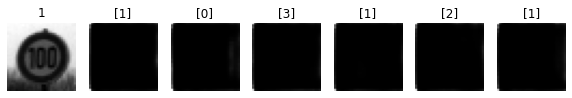

Epoch 151 g_loss= 0.85655904 d_loss= 0.7164709 real_acc= 0.16 fake_acc= 0.94
Epoch 152 g_loss= 0.8657282 d_loss= 0.7216296 real_acc= 0.14 fake_acc= 0.92
Epoch 153 g_loss= 0.8208177 d_loss= 0.7016739 real_acc= 0.32 fake_acc= 0.86
Epoch 154 g_loss= 0.84154433 d_loss= 0.7172936 real_acc= 0.22 fake_acc= 0.9
Epoch 155 g_loss= 0.82107085 d_loss= 0.7191287 real_acc= 0.18 fake_acc= 0.86
Epoch 156 g_loss= 0.8175668 d_loss= 0.7016389 real_acc= 0.42 fake_acc= 0.76
Epoch 157 g_loss= 0.81739366 d_loss= 0.69198763 real_acc= 0.36 fake_acc= 0.88
Epoch 158 g_loss= 0.8254202 d_loss= 0.71071744 real_acc= 0.26 fake_acc= 0.9
Epoch 159 g_loss= 0.83113843 d_loss= 0.69455934 real_acc= 0.32 fake_acc= 0.86
Epoch 160 g_loss= 0.84062225 d_loss= 0.666741 real_acc= 0.38 fake_acc= 0.92


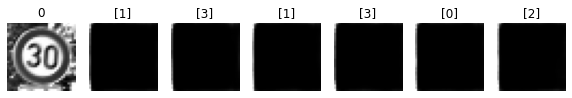

Epoch 161 g_loss= 0.8338884 d_loss= 0.6482516 real_acc= 0.54 fake_acc= 0.92
Epoch 162 g_loss= 0.8635103 d_loss= 0.64456224 real_acc= 0.52 fake_acc= 0.88
Epoch 163 g_loss= 0.8495194 d_loss= 0.64391154 real_acc= 0.52 fake_acc= 0.94
Epoch 164 g_loss= 0.88118637 d_loss= 0.6366638 real_acc= 0.52 fake_acc= 0.88
Epoch 165 g_loss= 0.89207155 d_loss= 0.60595334 real_acc= 0.64 fake_acc= 0.96
Epoch 166 g_loss= 0.89284384 d_loss= 0.61374754 real_acc= 0.68 fake_acc= 0.94
Epoch 167 g_loss= 0.88595927 d_loss= 0.6142355 real_acc= 0.66 fake_acc= 0.92
Epoch 168 g_loss= 0.939459 d_loss= 0.59351516 real_acc= 0.68 fake_acc= 1.0
Epoch 169 g_loss= 0.91329485 d_loss= 0.5869551 real_acc= 0.74 fake_acc= 0.98
Epoch 170 g_loss= 0.95382875 d_loss= 0.5837631 real_acc= 0.68 fake_acc= 0.92


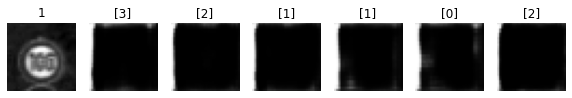

Epoch 171 g_loss= 0.9414169 d_loss= 0.5598128 real_acc= 0.86 fake_acc= 0.98
Epoch 172 g_loss= 0.9543129 d_loss= 0.5768867 real_acc= 0.64 fake_acc= 0.92
Epoch 173 g_loss= 0.92995363 d_loss= 0.57098 real_acc= 0.74 fake_acc= 0.88
Epoch 174 g_loss= 0.9198275 d_loss= 0.5725117 real_acc= 0.82 fake_acc= 0.86
Epoch 175 g_loss= 0.9090165 d_loss= 0.5648576 real_acc= 0.82 fake_acc= 0.92
Epoch 176 g_loss= 0.90948766 d_loss= 0.57220143 real_acc= 0.82 fake_acc= 0.86
Epoch 177 g_loss= 0.8826117 d_loss= 0.5791703 real_acc= 0.82 fake_acc= 0.78
Epoch 178 g_loss= 0.88940865 d_loss= 0.5592481 real_acc= 0.92 fake_acc= 0.78
Epoch 179 g_loss= 0.8959305 d_loss= 0.5848969 real_acc= 0.82 fake_acc= 0.78
Epoch 180 g_loss= 0.86179185 d_loss= 0.6002521 real_acc= 0.82 fake_acc= 0.7


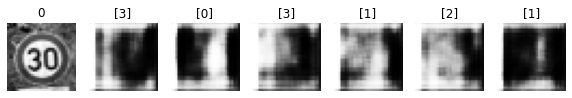

Epoch 181 g_loss= 0.87688905 d_loss= 0.5790533 real_acc= 0.76 fake_acc= 0.84
Epoch 182 g_loss= 0.87429476 d_loss= 0.6010364 real_acc= 0.74 fake_acc= 0.82
Epoch 183 g_loss= 0.81898654 d_loss= 0.62856793 real_acc= 0.66 fake_acc= 0.7
Epoch 184 g_loss= 0.8574373 d_loss= 0.5978061 real_acc= 0.78 fake_acc= 0.74
Epoch 185 g_loss= 0.8938158 d_loss= 0.6031028 real_acc= 0.76 fake_acc= 0.74
Epoch 186 g_loss= 0.94550824 d_loss= 0.61453974 real_acc= 0.64 fake_acc= 0.86
Epoch 187 g_loss= 0.92524064 d_loss= 0.60111177 real_acc= 0.66 fake_acc= 0.84
Epoch 188 g_loss= 0.86959857 d_loss= 0.64931625 real_acc= 0.58 fake_acc= 0.72
Epoch 189 g_loss= 0.8967949 d_loss= 0.6139567 real_acc= 0.68 fake_acc= 0.7
Epoch 190 g_loss= 0.93519175 d_loss= 0.63163483 real_acc= 0.54 fake_acc= 0.78


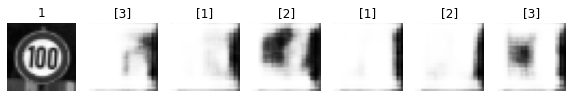

Epoch 191 g_loss= 0.90876967 d_loss= 0.67423046 real_acc= 0.56 fake_acc= 0.74
Epoch 192 g_loss= 0.9452183 d_loss= 0.63788426 real_acc= 0.68 fake_acc= 0.9
Epoch 193 g_loss= 0.96592635 d_loss= 0.5519387 real_acc= 0.84 fake_acc= 0.84
Epoch 194 g_loss= 0.9574561 d_loss= 0.67300254 real_acc= 0.56 fake_acc= 0.9
Epoch 195 g_loss= 0.99164414 d_loss= 0.6271639 real_acc= 0.56 fake_acc= 0.92
Epoch 196 g_loss= 0.91735995 d_loss= 0.6113336 real_acc= 0.62 fake_acc= 0.84
Epoch 197 g_loss= 0.94737715 d_loss= 0.6133853 real_acc= 0.62 fake_acc= 0.86
Epoch 198 g_loss= 0.9104287 d_loss= 0.59333146 real_acc= 0.64 fake_acc= 0.82
Epoch 199 g_loss= 0.8950393 d_loss= 0.6687676 real_acc= 0.5 fake_acc= 0.84
Epoch 200 g_loss= 0.93025774 d_loss= 0.62987876 real_acc= 0.64 fake_acc= 0.8


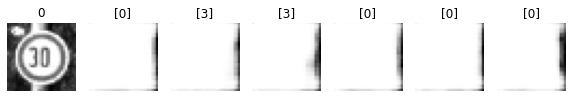

Epoch 201 g_loss= 0.8667791 d_loss= 0.64348817 real_acc= 0.6 fake_acc= 0.84
Epoch 202 g_loss= 0.9409158 d_loss= 0.609917 real_acc= 0.62 fake_acc= 0.82
Epoch 203 g_loss= 0.9171568 d_loss= 0.6406036 real_acc= 0.62 fake_acc= 0.78
Epoch 204 g_loss= 0.9708633 d_loss= 0.6093519 real_acc= 0.6 fake_acc= 0.74
Epoch 205 g_loss= 0.9790653 d_loss= 0.60912365 real_acc= 0.6 fake_acc= 0.8
Epoch 206 g_loss= 0.9653879 d_loss= 0.58846784 real_acc= 0.74 fake_acc= 0.8
Epoch 207 g_loss= 0.98775345 d_loss= 0.5908519 real_acc= 0.7 fake_acc= 0.82
Epoch 208 g_loss= 1.0284442 d_loss= 0.59962106 real_acc= 0.66 fake_acc= 0.84
Epoch 209 g_loss= 1.0970483 d_loss= 0.625759 real_acc= 0.58 fake_acc= 0.86
Epoch 210 g_loss= 1.0698658 d_loss= 0.6188452 real_acc= 0.64 fake_acc= 0.8


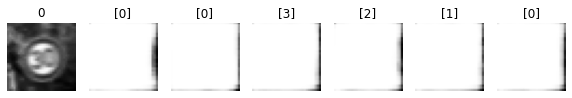

Epoch 211 g_loss= 1.1291258 d_loss= 0.587401 real_acc= 0.56 fake_acc= 0.84
Epoch 212 g_loss= 1.1394142 d_loss= 0.60067487 real_acc= 0.6 fake_acc= 0.9
Epoch 213 g_loss= 1.1617844 d_loss= 0.6200799 real_acc= 0.58 fake_acc= 0.84
Epoch 214 g_loss= 1.1249145 d_loss= 0.57723767 real_acc= 0.72 fake_acc= 0.7
Epoch 215 g_loss= 1.0715927 d_loss= 0.6007824 real_acc= 0.64 fake_acc= 0.76
Epoch 216 g_loss= 1.0401831 d_loss= 0.61842895 real_acc= 0.62 fake_acc= 0.74
Epoch 217 g_loss= 1.0252302 d_loss= 0.5938412 real_acc= 0.7 fake_acc= 0.72
Epoch 218 g_loss= 1.0402234 d_loss= 0.587443 real_acc= 0.68 fake_acc= 0.68
Epoch 219 g_loss= 0.9621394 d_loss= 0.56802136 real_acc= 0.82 fake_acc= 0.56
Epoch 220 g_loss= 1.0646291 d_loss= 0.51618874 real_acc= 0.92 fake_acc= 0.72


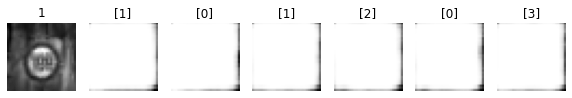

Epoch 221 g_loss= 1.0339018 d_loss= 0.5400339 real_acc= 0.88 fake_acc= 0.7
Epoch 222 g_loss= 1.0455475 d_loss= 0.5801258 real_acc= 0.84 fake_acc= 0.62
Epoch 223 g_loss= 1.1325587 d_loss= 0.53999686 real_acc= 0.78 fake_acc= 0.7
Epoch 224 g_loss= 1.0848333 d_loss= 0.5774734 real_acc= 0.74 fake_acc= 0.68
Epoch 225 g_loss= 1.0834591 d_loss= 0.57766736 real_acc= 0.72 fake_acc= 0.62
Epoch 226 g_loss= 1.1218728 d_loss= 0.5533279 real_acc= 0.74 fake_acc= 0.74
Epoch 227 g_loss= 1.1852416 d_loss= 0.51834387 real_acc= 0.84 fake_acc= 0.74
Epoch 228 g_loss= 1.217557 d_loss= 0.5029335 real_acc= 0.8 fake_acc= 0.78
Epoch 229 g_loss= 1.21967 d_loss= 0.50990736 real_acc= 0.72 fake_acc= 0.72
Epoch 230 g_loss= 1.2126136 d_loss= 0.49299276 real_acc= 0.86 fake_acc= 0.82


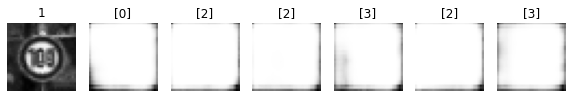

Epoch 231 g_loss= 1.1961381 d_loss= 0.47294652 real_acc= 0.9 fake_acc= 0.74
Epoch 232 g_loss= 1.1630985 d_loss= 0.5106424 real_acc= 0.86 fake_acc= 0.78
Epoch 233 g_loss= 1.0373776 d_loss= 0.5202042 real_acc= 0.82 fake_acc= 0.8
Epoch 234 g_loss= 1.0725391 d_loss= 0.48043787 real_acc= 0.9 fake_acc= 0.76
Epoch 235 g_loss= 1.1039981 d_loss= 0.4957615 real_acc= 0.84 fake_acc= 0.76
Epoch 236 g_loss= 1.0527538 d_loss= 0.51487184 real_acc= 0.78 fake_acc= 0.82
Epoch 237 g_loss= 1.0888869 d_loss= 0.5016392 real_acc= 0.84 fake_acc= 0.76
Epoch 238 g_loss= 0.9749884 d_loss= 0.5573484 real_acc= 0.8 fake_acc= 0.68
Epoch 239 g_loss= 0.9508313 d_loss= 0.5572536 real_acc= 0.92 fake_acc= 0.66
Epoch 240 g_loss= 1.0684432 d_loss= 0.5292112 real_acc= 0.86 fake_acc= 0.78


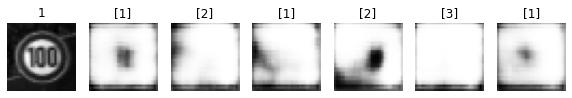

Epoch 241 g_loss= 1.1009523 d_loss= 0.5482074 real_acc= 0.78 fake_acc= 0.76
Epoch 242 g_loss= 0.9733815 d_loss= 0.59384143 real_acc= 0.7 fake_acc= 0.78
Epoch 243 g_loss= 0.9351441 d_loss= 0.5779124 real_acc= 0.76 fake_acc= 0.72
Epoch 244 g_loss= 0.92819303 d_loss= 0.64951086 real_acc= 0.66 fake_acc= 0.64
Epoch 245 g_loss= 0.9669798 d_loss= 0.61917347 real_acc= 0.74 fake_acc= 0.72
Epoch 246 g_loss= 0.8774392 d_loss= 0.69967234 real_acc= 0.58 fake_acc= 0.66
Epoch 247 g_loss= 0.7710038 d_loss= 0.74288636 real_acc= 0.56 fake_acc= 0.52
Epoch 248 g_loss= 0.7548229 d_loss= 0.7562756 real_acc= 0.72 fake_acc= 0.54
Epoch 249 g_loss= 0.73162127 d_loss= 0.69444275 real_acc= 0.72 fake_acc= 0.48
Epoch 250 g_loss= 0.7688465 d_loss= 0.74387085 real_acc= 0.58 fake_acc= 0.48


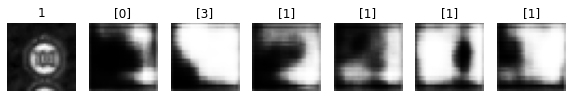

Epoch 251 g_loss= 0.79222125 d_loss= 0.7982163 real_acc= 0.54 fake_acc= 0.46
Epoch 252 g_loss= 0.797992 d_loss= 0.81209385 real_acc= 0.52 fake_acc= 0.54
Epoch 253 g_loss= 0.9026097 d_loss= 0.78521204 real_acc= 0.46 fake_acc= 0.54
Epoch 254 g_loss= 0.86356354 d_loss= 0.8239205 real_acc= 0.52 fake_acc= 0.58
Epoch 255 g_loss= 0.807972 d_loss= 0.7844124 real_acc= 0.48 fake_acc= 0.46
Epoch 256 g_loss= 0.76928794 d_loss= 0.7639086 real_acc= 0.54 fake_acc= 0.46
Epoch 257 g_loss= 0.76131403 d_loss= 0.8869809 real_acc= 0.38 fake_acc= 0.46
Epoch 258 g_loss= 0.7668871 d_loss= 0.78023946 real_acc= 0.58 fake_acc= 0.48
Epoch 259 g_loss= 0.8477842 d_loss= 0.7093099 real_acc= 0.6 fake_acc= 0.54
Epoch 260 g_loss= 0.8460538 d_loss= 0.6329222 real_acc= 0.74 fake_acc= 0.66


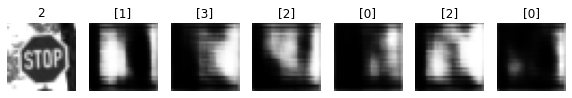

Epoch 261 g_loss= 0.87196404 d_loss= 0.68953407 real_acc= 0.62 fake_acc= 0.6
Epoch 262 g_loss= 0.85206527 d_loss= 0.70830154 real_acc= 0.64 fake_acc= 0.58
Epoch 263 g_loss= 0.8790354 d_loss= 0.66701704 real_acc= 0.72 fake_acc= 0.52
Epoch 264 g_loss= 0.9366104 d_loss= 0.6943269 real_acc= 0.62 fake_acc= 0.68
Epoch 265 g_loss= 1.0161504 d_loss= 0.6421015 real_acc= 0.66 fake_acc= 0.72
Epoch 266 g_loss= 1.0133437 d_loss= 0.6905291 real_acc= 0.52 fake_acc= 0.84
Epoch 267 g_loss= 0.97307616 d_loss= 0.6768656 real_acc= 0.66 fake_acc= 0.72
Epoch 268 g_loss= 1.024587 d_loss= 0.6809961 real_acc= 0.62 fake_acc= 0.74
Epoch 269 g_loss= 0.8926792 d_loss= 0.65450966 real_acc= 0.6 fake_acc= 0.62
Epoch 270 g_loss= 0.90472305 d_loss= 0.6085551 real_acc= 0.8 fake_acc= 0.64


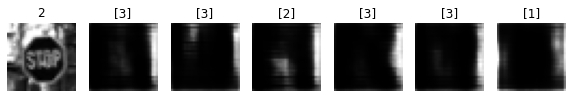

Epoch 271 g_loss= 0.92008543 d_loss= 0.61152625 real_acc= 0.68 fake_acc= 0.62
Epoch 272 g_loss= 0.98852915 d_loss= 0.5843388 real_acc= 0.72 fake_acc= 0.68
Epoch 273 g_loss= 0.90869707 d_loss= 0.5834564 real_acc= 0.76 fake_acc= 0.68
Epoch 274 g_loss= 0.9907175 d_loss= 0.5665673 real_acc= 0.68 fake_acc= 0.68
Epoch 275 g_loss= 1.0597844 d_loss= 0.5374166 real_acc= 0.78 fake_acc= 0.84
Epoch 276 g_loss= 1.0591929 d_loss= 0.56381226 real_acc= 0.66 fake_acc= 0.8
Epoch 277 g_loss= 1.1291265 d_loss= 0.50478524 real_acc= 0.78 fake_acc= 0.8
Epoch 278 g_loss= 1.1509163 d_loss= 0.57731885 real_acc= 0.62 fake_acc= 0.84
Epoch 279 g_loss= 1.155786 d_loss= 0.5287593 real_acc= 0.74 fake_acc= 0.86
Epoch 280 g_loss= 1.2767181 d_loss= 0.50234735 real_acc= 0.68 fake_acc= 0.86


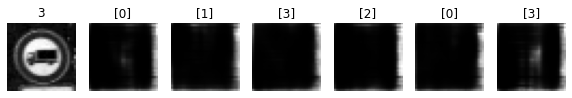

Epoch 281 g_loss= 1.2347572 d_loss= 0.49752736 real_acc= 0.72 fake_acc= 0.9
Epoch 282 g_loss= 1.3058988 d_loss= 0.4798296 real_acc= 0.72 fake_acc= 0.98
Epoch 283 g_loss= 1.2280183 d_loss= 0.47462493 real_acc= 0.76 fake_acc= 0.88
Epoch 284 g_loss= 1.1954684 d_loss= 0.5175015 real_acc= 0.64 fake_acc= 0.82
Epoch 285 g_loss= 1.1176462 d_loss= 0.51814365 real_acc= 0.7 fake_acc= 0.84
Epoch 286 g_loss= 1.1957154 d_loss= 0.51478153 real_acc= 0.78 fake_acc= 0.94
Epoch 287 g_loss= 1.0526446 d_loss= 0.51933587 real_acc= 0.82 fake_acc= 0.78
Epoch 288 g_loss= 1.1114246 d_loss= 0.47067297 real_acc= 0.8 fake_acc= 0.86
Epoch 289 g_loss= 1.0093143 d_loss= 0.4619491 real_acc= 0.92 fake_acc= 0.82
Epoch 290 g_loss= 1.0884951 d_loss= 0.4297247 real_acc= 0.86 fake_acc= 0.86


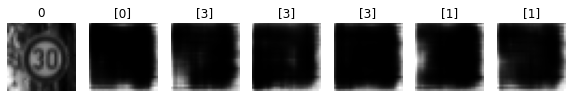

Epoch 291 g_loss= 1.0529088 d_loss= 0.49782735 real_acc= 0.8 fake_acc= 0.82
Epoch 292 g_loss= 1.1984547 d_loss= 0.4144349 real_acc= 0.82 fake_acc= 0.86
Epoch 293 g_loss= 1.0565988 d_loss= 0.46418673 real_acc= 0.82 fake_acc= 0.76
Epoch 294 g_loss= 1.2184477 d_loss= 0.4531672 real_acc= 0.74 fake_acc= 0.88
Epoch 295 g_loss= 1.2021774 d_loss= 0.44308957 real_acc= 0.82 fake_acc= 0.84
Epoch 296 g_loss= 1.1439011 d_loss= 0.4682794 real_acc= 0.82 fake_acc= 0.88
Epoch 297 g_loss= 1.3518972 d_loss= 0.39930248 real_acc= 0.82 fake_acc= 0.92
Epoch 298 g_loss= 1.255726 d_loss= 0.46190202 real_acc= 0.82 fake_acc= 0.88
Epoch 299 g_loss= 1.3758832 d_loss= 0.39260796 real_acc= 0.86 fake_acc= 0.84
Epoch 300 g_loss= 1.2095753 d_loss= 0.50393665 real_acc= 0.74 fake_acc= 0.88


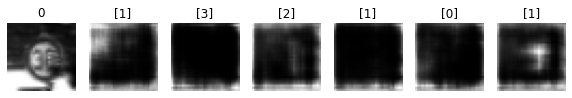

Epoch 301 g_loss= 1.0914372 d_loss= 0.51886076 real_acc= 0.72 fake_acc= 0.84
Epoch 302 g_loss= 1.1603937 d_loss= 0.52723897 real_acc= 0.66 fake_acc= 0.78
Epoch 303 g_loss= 1.0400392 d_loss= 0.5885066 real_acc= 0.68 fake_acc= 0.68
Epoch 304 g_loss= 0.9452121 d_loss= 0.6246741 real_acc= 0.66 fake_acc= 0.62
Epoch 305 g_loss= 0.99157774 d_loss= 0.65742016 real_acc= 0.58 fake_acc= 0.74
Epoch 306 g_loss= 0.9786635 d_loss= 0.629665 real_acc= 0.62 fake_acc= 0.66
Epoch 307 g_loss= 0.8607451 d_loss= 0.6614735 real_acc= 0.76 fake_acc= 0.56
Epoch 308 g_loss= 0.73078036 d_loss= 0.62383854 real_acc= 0.76 fake_acc= 0.44
Epoch 309 g_loss= 0.8062395 d_loss= 0.6352173 real_acc= 0.76 fake_acc= 0.58
Epoch 310 g_loss= 0.79288095 d_loss= 0.67245555 real_acc= 0.74 fake_acc= 0.52


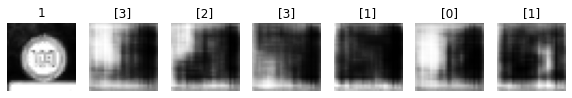

Epoch 311 g_loss= 0.7963467 d_loss= 0.67711616 real_acc= 0.72 fake_acc= 0.62
Epoch 312 g_loss= 0.8239363 d_loss= 0.6924908 real_acc= 0.6 fake_acc= 0.62
Epoch 313 g_loss= 0.80289507 d_loss= 0.79047275 real_acc= 0.56 fake_acc= 0.62
Epoch 314 g_loss= 0.98222846 d_loss= 0.7317859 real_acc= 0.5 fake_acc= 0.72
Epoch 315 g_loss= 1.0035796 d_loss= 0.6935761 real_acc= 0.6 fake_acc= 0.78
Epoch 316 g_loss= 1.0634146 d_loss= 0.7208162 real_acc= 0.5 fake_acc= 0.74
Epoch 317 g_loss= 0.98728144 d_loss= 0.7783731 real_acc= 0.52 fake_acc= 0.68
Epoch 318 g_loss= 0.90360594 d_loss= 0.6307517 real_acc= 0.68 fake_acc= 0.66
Epoch 319 g_loss= 0.92367744 d_loss= 0.622 real_acc= 0.6 fake_acc= 0.7
Epoch 320 g_loss= 0.9257025 d_loss= 0.6340505 real_acc= 0.66 fake_acc= 0.74


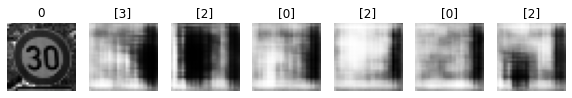

Epoch 321 g_loss= 0.88692063 d_loss= 0.58801043 real_acc= 0.78 fake_acc= 0.76
Epoch 322 g_loss= 0.91590655 d_loss= 0.59423596 real_acc= 0.7 fake_acc= 0.74
Epoch 323 g_loss= 0.8745535 d_loss= 0.64523256 real_acc= 0.6 fake_acc= 0.7
Epoch 324 g_loss= 0.8670125 d_loss= 0.603174 real_acc= 0.74 fake_acc= 0.66
Epoch 325 g_loss= 0.8598968 d_loss= 0.64488316 real_acc= 0.64 fake_acc= 0.68
Epoch 326 g_loss= 0.83561903 d_loss= 0.67749023 real_acc= 0.64 fake_acc= 0.56
Epoch 327 g_loss= 0.87480545 d_loss= 0.60104936 real_acc= 0.7 fake_acc= 0.58
Epoch 328 g_loss= 0.97131616 d_loss= 0.6869409 real_acc= 0.58 fake_acc= 0.76
Epoch 329 g_loss= 0.9352745 d_loss= 0.6370668 real_acc= 0.64 fake_acc= 0.7
Epoch 330 g_loss= 0.99535507 d_loss= 0.60909283 real_acc= 0.66 fake_acc= 0.8


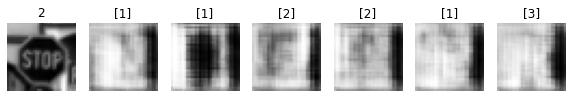

Epoch 331 g_loss= 0.9404951 d_loss= 0.6006057 real_acc= 0.68 fake_acc= 0.74
Epoch 332 g_loss= 0.9336813 d_loss= 0.68638587 real_acc= 0.54 fake_acc= 0.76
Epoch 333 g_loss= 0.9581375 d_loss= 0.61797667 real_acc= 0.56 fake_acc= 0.76
Epoch 334 g_loss= 0.8839323 d_loss= 0.5728636 real_acc= 0.76 fake_acc= 0.74
Epoch 335 g_loss= 0.9141111 d_loss= 0.5509813 real_acc= 0.78 fake_acc= 0.7
Epoch 336 g_loss= 0.99612725 d_loss= 0.64444375 real_acc= 0.58 fake_acc= 0.78
Epoch 337 g_loss= 0.85791016 d_loss= 0.6177968 real_acc= 0.74 fake_acc= 0.62
Epoch 338 g_loss= 0.9234565 d_loss= 0.6339168 real_acc= 0.66 fake_acc= 0.76
Epoch 339 g_loss= 0.9276928 d_loss= 0.6679771 real_acc= 0.62 fake_acc= 0.68
Epoch 340 g_loss= 0.9576885 d_loss= 0.6297675 real_acc= 0.62 fake_acc= 0.72


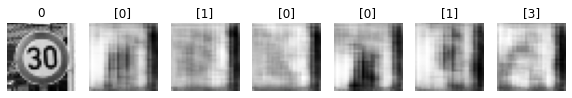

Epoch 341 g_loss= 0.9130791 d_loss= 0.5921903 real_acc= 0.74 fake_acc= 0.7
Epoch 342 g_loss= 0.87875336 d_loss= 0.5927497 real_acc= 0.72 fake_acc= 0.68
Epoch 343 g_loss= 1.0065995 d_loss= 0.57283604 real_acc= 0.66 fake_acc= 0.76
Epoch 344 g_loss= 0.89658093 d_loss= 0.62217593 real_acc= 0.76 fake_acc= 0.64
Epoch 345 g_loss= 0.91987467 d_loss= 0.63561285 real_acc= 0.66 fake_acc= 0.68
Epoch 346 g_loss= 0.92353654 d_loss= 0.58534276 real_acc= 0.68 fake_acc= 0.74
Epoch 347 g_loss= 0.9119544 d_loss= 0.6152876 real_acc= 0.66 fake_acc= 0.7
Epoch 348 g_loss= 0.8694177 d_loss= 0.63699603 real_acc= 0.7 fake_acc= 0.6
Epoch 349 g_loss= 0.8731488 d_loss= 0.6172273 real_acc= 0.64 fake_acc= 0.62
Epoch 350 g_loss= 0.8318993 d_loss= 0.6473375 real_acc= 0.68 fake_acc= 0.56


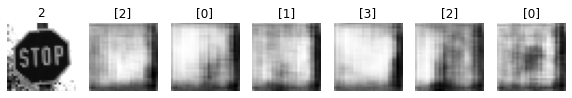

Epoch 351 g_loss= 0.87640834 d_loss= 0.590944 real_acc= 0.74 fake_acc= 0.6
Epoch 352 g_loss= 0.8686736 d_loss= 0.626689 real_acc= 0.72 fake_acc= 0.66
Epoch 353 g_loss= 0.8679657 d_loss= 0.61095655 real_acc= 0.76 fake_acc= 0.58
Epoch 354 g_loss= 0.8539527 d_loss= 0.6278961 real_acc= 0.68 fake_acc= 0.6
Epoch 355 g_loss= 0.8774378 d_loss= 0.57550716 real_acc= 0.8 fake_acc= 0.58
Epoch 356 g_loss= 0.8281316 d_loss= 0.6855598 real_acc= 0.64 fake_acc= 0.6
Epoch 357 g_loss= 0.8392633 d_loss= 0.5986585 real_acc= 0.76 fake_acc= 0.54
Epoch 358 g_loss= 0.8032668 d_loss= 0.6356603 real_acc= 0.76 fake_acc= 0.52
Epoch 359 g_loss= 0.8022237 d_loss= 0.5966264 real_acc= 0.82 fake_acc= 0.54
Epoch 360 g_loss= 0.8225285 d_loss= 0.58880216 real_acc= 0.78 fake_acc= 0.56


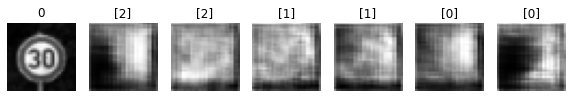

Epoch 361 g_loss= 0.7741321 d_loss= 0.6464941 real_acc= 0.7 fake_acc= 0.52
Epoch 362 g_loss= 0.7795185 d_loss= 0.6122904 real_acc= 0.82 fake_acc= 0.54
Epoch 363 g_loss= 0.6782859 d_loss= 0.6453775 real_acc= 0.82 fake_acc= 0.38
Epoch 364 g_loss= 0.7730262 d_loss= 0.6200967 real_acc= 0.76 fake_acc= 0.56
Epoch 365 g_loss= 0.7160135 d_loss= 0.6859802 real_acc= 0.74 fake_acc= 0.42
Epoch 366 g_loss= 0.74627745 d_loss= 0.6156534 real_acc= 0.86 fake_acc= 0.52
Epoch 367 g_loss= 0.7333635 d_loss= 0.6627909 real_acc= 0.74 fake_acc= 0.5
Epoch 368 g_loss= 0.7479435 d_loss= 0.6512368 real_acc= 0.8 fake_acc= 0.48
Epoch 369 g_loss= 0.6992342 d_loss= 0.6857285 real_acc= 0.78 fake_acc= 0.4
Epoch 370 g_loss= 0.6606739 d_loss= 0.74182284 real_acc= 0.66 fake_acc= 0.36


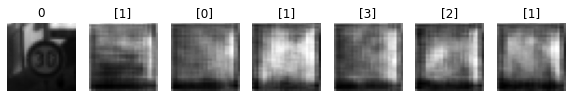

Epoch 371 g_loss= 0.77599436 d_loss= 0.7077838 real_acc= 0.66 fake_acc= 0.54
Epoch 372 g_loss= 0.6799812 d_loss= 0.7602784 real_acc= 0.6 fake_acc= 0.42
Epoch 373 g_loss= 0.6626391 d_loss= 0.75720084 real_acc= 0.64 fake_acc= 0.44
Epoch 374 g_loss= 0.6748091 d_loss= 0.70705765 real_acc= 0.72 fake_acc= 0.42
Epoch 375 g_loss= 0.5824326 d_loss= 0.7700622 real_acc= 0.76 fake_acc= 0.24
Epoch 376 g_loss= 0.6354333 d_loss= 0.7522241 real_acc= 0.64 fake_acc= 0.36
Epoch 377 g_loss= 0.63709086 d_loss= 0.7221948 real_acc= 0.72 fake_acc= 0.36
Epoch 378 g_loss= 0.56755847 d_loss= 0.78289026 real_acc= 0.72 fake_acc= 0.2
Epoch 379 g_loss= 0.6042477 d_loss= 0.72446334 real_acc= 0.84 fake_acc= 0.34
Epoch 380 g_loss= 0.5615121 d_loss= 0.79956704 real_acc= 0.68 fake_acc= 0.38


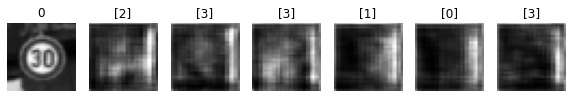

Epoch 381 g_loss= 0.55219436 d_loss= 0.79992545 real_acc= 0.64 fake_acc= 0.22
Epoch 382 g_loss= 0.6393947 d_loss= 0.7904705 real_acc= 0.58 fake_acc= 0.4
Epoch 383 g_loss= 0.64455926 d_loss= 0.7501852 real_acc= 0.6 fake_acc= 0.38
Epoch 384 g_loss= 0.6606062 d_loss= 0.7190592 real_acc= 0.72 fake_acc= 0.34
Epoch 385 g_loss= 0.6313603 d_loss= 0.7829734 real_acc= 0.58 fake_acc= 0.28
Epoch 386 g_loss= 0.6410806 d_loss= 0.70260227 real_acc= 0.74 fake_acc= 0.28
Epoch 387 g_loss= 0.70390326 d_loss= 0.7133844 real_acc= 0.58 fake_acc= 0.46
Epoch 388 g_loss= 0.6961487 d_loss= 0.70632875 real_acc= 0.64 fake_acc= 0.4
Epoch 389 g_loss= 0.6578279 d_loss= 0.6866183 real_acc= 0.7 fake_acc= 0.38
Epoch 390 g_loss= 0.7408222 d_loss= 0.66841555 real_acc= 0.64 fake_acc= 0.5


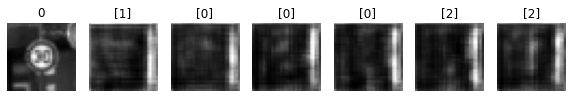

Epoch 391 g_loss= 0.7159059 d_loss= 0.71053165 real_acc= 0.48 fake_acc= 0.56
Epoch 392 g_loss= 0.7313186 d_loss= 0.66612005 real_acc= 0.64 fake_acc= 0.5
Epoch 393 g_loss= 0.7723149 d_loss= 0.6369994 real_acc= 0.72 fake_acc= 0.58
Epoch 394 g_loss= 0.7129295 d_loss= 0.67219865 real_acc= 0.58 fake_acc= 0.56
Epoch 395 g_loss= 0.79947823 d_loss= 0.62748104 real_acc= 0.66 fake_acc= 0.68
Epoch 396 g_loss= 0.78227687 d_loss= 0.6396872 real_acc= 0.62 fake_acc= 0.66
Epoch 397 g_loss= 0.9016835 d_loss= 0.5766705 real_acc= 0.72 fake_acc= 0.76
Epoch 398 g_loss= 0.9329804 d_loss= 0.5480355 real_acc= 0.7 fake_acc= 0.86
Epoch 399 g_loss= 0.8982666 d_loss= 0.5540931 real_acc= 0.78 fake_acc= 0.74
Epoch 400 g_loss= 0.9980968 d_loss= 0.545755 real_acc= 0.62 fake_acc= 0.82


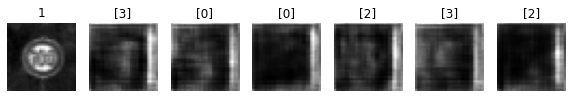

Epoch 401 g_loss= 0.9669115 d_loss= 0.55399215 real_acc= 0.7 fake_acc= 0.68
Epoch 402 g_loss= 1.0529045 d_loss= 0.5551187 real_acc= 0.62 fake_acc= 0.8
Epoch 403 g_loss= 0.9733442 d_loss= 0.5757109 real_acc= 0.6 fake_acc= 0.76
Epoch 404 g_loss= 1.0770129 d_loss= 0.54511195 real_acc= 0.64 fake_acc= 0.84
Epoch 405 g_loss= 1.0458286 d_loss= 0.52196074 real_acc= 0.66 fake_acc= 0.76
Epoch 406 g_loss= 0.967189 d_loss= 0.5266701 real_acc= 0.76 fake_acc= 0.72
Epoch 407 g_loss= 0.9645807 d_loss= 0.55385447 real_acc= 0.74 fake_acc= 0.72
Epoch 408 g_loss= 1.0307021 d_loss= 0.50085104 real_acc= 0.76 fake_acc= 0.8
Epoch 409 g_loss= 0.99675506 d_loss= 0.51002634 real_acc= 0.8 fake_acc= 0.72
Epoch 410 g_loss= 0.9157274 d_loss= 0.51989913 real_acc= 0.82 fake_acc= 0.72


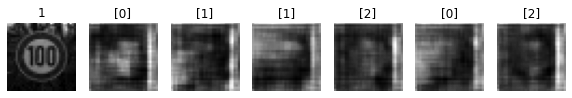

Epoch 411 g_loss= 1.032699 d_loss= 0.51465017 real_acc= 0.7 fake_acc= 0.86
Epoch 412 g_loss= 1.0656952 d_loss= 0.48401687 real_acc= 0.72 fake_acc= 0.86
Epoch 413 g_loss= 0.98673785 d_loss= 0.48809054 real_acc= 0.76 fake_acc= 0.76
Epoch 414 g_loss= 0.97850585 d_loss= 0.52186036 real_acc= 0.82 fake_acc= 0.7
Epoch 415 g_loss= 1.1051533 d_loss= 0.47031736 real_acc= 0.78 fake_acc= 0.86
Epoch 416 g_loss= 1.0688313 d_loss= 0.4901719 real_acc= 0.76 fake_acc= 0.84
Epoch 417 g_loss= 1.018423 d_loss= 0.44946554 real_acc= 0.9 fake_acc= 0.88
Epoch 418 g_loss= 0.9845722 d_loss= 0.51812613 real_acc= 0.8 fake_acc= 0.74
Epoch 419 g_loss= 0.98623794 d_loss= 0.5231421 real_acc= 0.68 fake_acc= 0.78
Epoch 420 g_loss= 0.97072524 d_loss= 0.5610241 real_acc= 0.66 fake_acc= 0.82


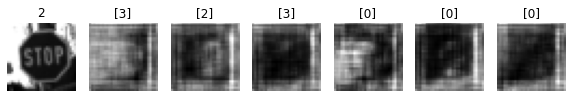

Epoch 421 g_loss= 1.0504866 d_loss= 0.5551444 real_acc= 0.58 fake_acc= 0.76
Epoch 422 g_loss= 1.0152078 d_loss= 0.5459491 real_acc= 0.6 fake_acc= 0.88
Epoch 423 g_loss= 1.0104941 d_loss= 0.53829134 real_acc= 0.66 fake_acc= 0.76
Epoch 424 g_loss= 0.93822944 d_loss= 0.5850717 real_acc= 0.66 fake_acc= 0.76
Epoch 425 g_loss= 0.9031369 d_loss= 0.5696672 real_acc= 0.78 fake_acc= 0.7
Epoch 426 g_loss= 0.8572705 d_loss= 0.60385853 real_acc= 0.68 fake_acc= 0.58
Epoch 427 g_loss= 0.79515105 d_loss= 0.6684251 real_acc= 0.62 fake_acc= 0.52
Epoch 428 g_loss= 0.7813588 d_loss= 0.69104326 real_acc= 0.58 fake_acc= 0.58
Epoch 429 g_loss= 0.7448122 d_loss= 0.7015925 real_acc= 0.62 fake_acc= 0.52
Epoch 430 g_loss= 0.80866754 d_loss= 0.70780385 real_acc= 0.54 fake_acc= 0.56


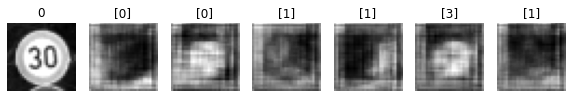

Epoch 431 g_loss= 0.793653 d_loss= 0.6265533 real_acc= 0.76 fake_acc= 0.56
Epoch 432 g_loss= 0.7544078 d_loss= 0.7339057 real_acc= 0.52 fake_acc= 0.5
Epoch 433 g_loss= 0.7562111 d_loss= 0.7259915 real_acc= 0.56 fake_acc= 0.54
Epoch 434 g_loss= 0.782887 d_loss= 0.7414003 real_acc= 0.46 fake_acc= 0.58
Epoch 435 g_loss= 0.78775895 d_loss= 0.70975566 real_acc= 0.64 fake_acc= 0.56
Epoch 436 g_loss= 0.74942017 d_loss= 0.73335403 real_acc= 0.46 fake_acc= 0.56
Epoch 437 g_loss= 0.79224145 d_loss= 0.73822457 real_acc= 0.48 fake_acc= 0.54
Epoch 438 g_loss= 0.7881848 d_loss= 0.6859285 real_acc= 0.6 fake_acc= 0.54
Epoch 439 g_loss= 0.7293857 d_loss= 0.7352043 real_acc= 0.54 fake_acc= 0.44
Epoch 440 g_loss= 0.7355556 d_loss= 0.73729545 real_acc= 0.6 fake_acc= 0.44


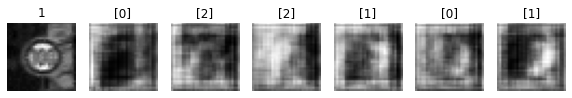

Epoch 441 g_loss= 0.7691478 d_loss= 0.7425009 real_acc= 0.44 fake_acc= 0.54
Epoch 442 g_loss= 0.75715363 d_loss= 0.7008501 real_acc= 0.58 fake_acc= 0.66
Epoch 443 g_loss= 0.76571935 d_loss= 0.72302175 real_acc= 0.44 fake_acc= 0.5
Epoch 444 g_loss= 0.6986908 d_loss= 0.72238874 real_acc= 0.66 fake_acc= 0.4
Epoch 445 g_loss= 0.6929077 d_loss= 0.7472826 real_acc= 0.54 fake_acc= 0.42
Epoch 446 g_loss= 0.7899015 d_loss= 0.7344357 real_acc= 0.4 fake_acc= 0.56
Epoch 447 g_loss= 0.7996693 d_loss= 0.697834 real_acc= 0.46 fake_acc= 0.56
Epoch 448 g_loss= 0.77746505 d_loss= 0.6887733 real_acc= 0.58 fake_acc= 0.5
Epoch 449 g_loss= 0.77122617 d_loss= 0.70721895 real_acc= 0.58 fake_acc= 0.54
Epoch 450 g_loss= 0.7711304 d_loss= 0.7524699 real_acc= 0.32 fake_acc= 0.54


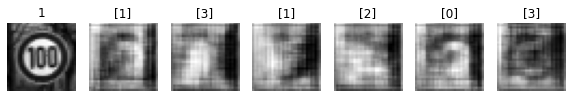

Epoch 451 g_loss= 0.8489139 d_loss= 0.69947946 real_acc= 0.48 fake_acc= 0.64
Epoch 452 g_loss= 0.8065609 d_loss= 0.6789923 real_acc= 0.48 fake_acc= 0.64
Epoch 453 g_loss= 0.80140084 d_loss= 0.68536735 real_acc= 0.54 fake_acc= 0.58
Epoch 454 g_loss= 0.88359445 d_loss= 0.6795289 real_acc= 0.46 fake_acc= 0.76
Epoch 455 g_loss= 0.80419487 d_loss= 0.6986481 real_acc= 0.44 fake_acc= 0.64
Epoch 456 g_loss= 0.8853418 d_loss= 0.65877956 real_acc= 0.48 fake_acc= 0.68
Epoch 457 g_loss= 0.80757064 d_loss= 0.6916212 real_acc= 0.48 fake_acc= 0.68
Epoch 458 g_loss= 0.781653 d_loss= 0.6887312 real_acc= 0.6 fake_acc= 0.6
Epoch 459 g_loss= 0.739146 d_loss= 0.7033349 real_acc= 0.6 fake_acc= 0.56
Epoch 460 g_loss= 0.72880036 d_loss= 0.71382236 real_acc= 0.54 fake_acc= 0.5


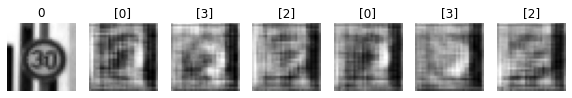

Epoch 461 g_loss= 0.77162796 d_loss= 0.68147767 real_acc= 0.64 fake_acc= 0.58
Epoch 462 g_loss= 0.86364657 d_loss= 0.64429253 real_acc= 0.54 fake_acc= 0.76
Epoch 463 g_loss= 0.8348414 d_loss= 0.6567879 real_acc= 0.58 fake_acc= 0.58
Epoch 464 g_loss= 0.7669963 d_loss= 0.67976713 real_acc= 0.58 fake_acc= 0.54
Epoch 465 g_loss= 0.8717393 d_loss= 0.6282741 real_acc= 0.64 fake_acc= 0.68
Epoch 466 g_loss= 0.83955646 d_loss= 0.64630413 real_acc= 0.6 fake_acc= 0.7
Epoch 467 g_loss= 0.8628012 d_loss= 0.6302967 real_acc= 0.54 fake_acc= 0.76
Epoch 468 g_loss= 0.8309012 d_loss= 0.6291956 real_acc= 0.58 fake_acc= 0.7
Epoch 469 g_loss= 0.88130295 d_loss= 0.67272294 real_acc= 0.54 fake_acc= 0.74
Epoch 470 g_loss= 0.84715706 d_loss= 0.60590285 real_acc= 0.7 fake_acc= 0.68


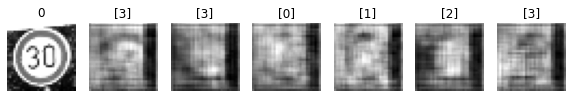

Epoch 471 g_loss= 0.8951223 d_loss= 0.6736244 real_acc= 0.48 fake_acc= 0.74
Epoch 472 g_loss= 0.84035254 d_loss= 0.64769244 real_acc= 0.56 fake_acc= 0.7
Epoch 473 g_loss= 0.9098408 d_loss= 0.67403316 real_acc= 0.44 fake_acc= 0.76
Epoch 474 g_loss= 0.8273457 d_loss= 0.6552433 real_acc= 0.58 fake_acc= 0.66
Epoch 475 g_loss= 0.9864067 d_loss= 0.6097034 real_acc= 0.62 fake_acc= 0.82
Epoch 476 g_loss= 0.912999 d_loss= 0.62196803 real_acc= 0.6 fake_acc= 0.74
Epoch 477 g_loss= 0.87265885 d_loss= 0.62709856 real_acc= 0.62 fake_acc= 0.7
Epoch 478 g_loss= 0.92227304 d_loss= 0.62749386 real_acc= 0.54 fake_acc= 0.8
Epoch 479 g_loss= 0.82160246 d_loss= 0.6515691 real_acc= 0.58 fake_acc= 0.68
Epoch 480 g_loss= 0.84763056 d_loss= 0.6146786 real_acc= 0.66 fake_acc= 0.7


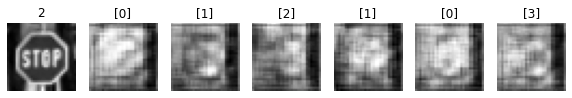

Epoch 481 g_loss= 0.8616134 d_loss= 0.61380684 real_acc= 0.72 fake_acc= 0.72
Epoch 482 g_loss= 0.8602394 d_loss= 0.6084825 real_acc= 0.74 fake_acc= 0.66
Epoch 483 g_loss= 0.8247827 d_loss= 0.6643261 real_acc= 0.54 fake_acc= 0.68
Epoch 484 g_loss= 0.82624656 d_loss= 0.67460716 real_acc= 0.6 fake_acc= 0.68
Epoch 485 g_loss= 0.89838976 d_loss= 0.624631 real_acc= 0.58 fake_acc= 0.8
Epoch 486 g_loss= 0.89852923 d_loss= 0.627155 real_acc= 0.56 fake_acc= 0.74
Epoch 487 g_loss= 0.9225763 d_loss= 0.5942962 real_acc= 0.64 fake_acc= 0.76
Epoch 488 g_loss= 0.991384 d_loss= 0.60789835 real_acc= 0.52 fake_acc= 0.74
Epoch 489 g_loss= 0.9050239 d_loss= 0.6215298 real_acc= 0.6 fake_acc= 0.7
Epoch 490 g_loss= 0.9279865 d_loss= 0.613716 real_acc= 0.5 fake_acc= 0.76


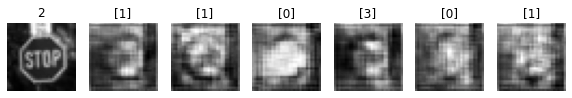

Epoch 491 g_loss= 0.96725947 d_loss= 0.6279552 real_acc= 0.56 fake_acc= 0.74
Epoch 492 g_loss= 0.8833487 d_loss= 0.6465775 real_acc= 0.6 fake_acc= 0.72
Epoch 493 g_loss= 0.9390025 d_loss= 0.6198884 real_acc= 0.52 fake_acc= 0.78
Epoch 494 g_loss= 0.9068904 d_loss= 0.63819635 real_acc= 0.56 fake_acc= 0.78
Epoch 495 g_loss= 0.91639435 d_loss= 0.63577527 real_acc= 0.54 fake_acc= 0.76
Epoch 496 g_loss= 0.9204622 d_loss= 0.6408316 real_acc= 0.6 fake_acc= 0.76
Epoch 497 g_loss= 0.9787062 d_loss= 0.59599316 real_acc= 0.62 fake_acc= 0.82
Epoch 498 g_loss= 0.8508794 d_loss= 0.6466472 real_acc= 0.66 fake_acc= 0.72
Epoch 499 g_loss= 0.83632094 d_loss= 0.668504 real_acc= 0.58 fake_acc= 0.62
Epoch 500 g_loss= 0.88743055 d_loss= 0.6154666 real_acc= 0.68 fake_acc= 0.74


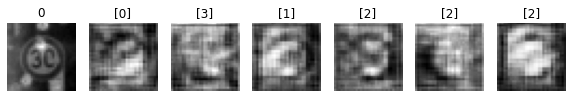

Epoch 501 g_loss= 0.8387196 d_loss= 0.6453254 real_acc= 0.62 fake_acc= 0.76
Epoch 502 g_loss= 0.7719302 d_loss= 0.6466849 real_acc= 0.74 fake_acc= 0.66
Epoch 503 g_loss= 0.8128046 d_loss= 0.6440191 real_acc= 0.68 fake_acc= 0.58
Epoch 504 g_loss= 0.73600525 d_loss= 0.6691743 real_acc= 0.7 fake_acc= 0.64
Epoch 505 g_loss= 0.83944213 d_loss= 0.6096705 real_acc= 0.74 fake_acc= 0.66
Epoch 506 g_loss= 0.83599573 d_loss= 0.65738064 real_acc= 0.68 fake_acc= 0.7
Epoch 507 g_loss= 0.7380663 d_loss= 0.6859382 real_acc= 0.68 fake_acc= 0.58
Epoch 508 g_loss= 0.8021309 d_loss= 0.68757874 real_acc= 0.56 fake_acc= 0.64
Epoch 509 g_loss= 0.773676 d_loss= 0.6454947 real_acc= 0.66 fake_acc= 0.66
Epoch 510 g_loss= 0.8819022 d_loss= 0.62346005 real_acc= 0.72 fake_acc= 0.72


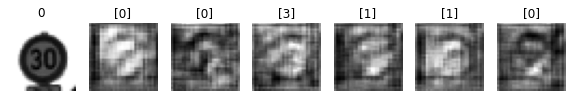

Epoch 511 g_loss= 0.7591558 d_loss= 0.66950965 real_acc= 0.74 fake_acc= 0.68
Epoch 512 g_loss= 0.81397027 d_loss= 0.6699454 real_acc= 0.62 fake_acc= 0.6
Epoch 513 g_loss= 0.7785004 d_loss= 0.65979326 real_acc= 0.68 fake_acc= 0.56
Epoch 514 g_loss= 0.75666153 d_loss= 0.67879295 real_acc= 0.64 fake_acc= 0.56
Epoch 515 g_loss= 0.8119415 d_loss= 0.6487454 real_acc= 0.68 fake_acc= 0.64
Epoch 516 g_loss= 0.7725827 d_loss= 0.68461525 real_acc= 0.64 fake_acc= 0.58
Epoch 517 g_loss= 0.7366079 d_loss= 0.66785043 real_acc= 0.7 fake_acc= 0.56
Epoch 518 g_loss= 0.89763784 d_loss= 0.6319617 real_acc= 0.6 fake_acc= 0.86
Epoch 519 g_loss= 0.82580805 d_loss= 0.6619351 real_acc= 0.68 fake_acc= 0.66
Epoch 520 g_loss= 0.77437776 d_loss= 0.67811465 real_acc= 0.64 fake_acc= 0.54


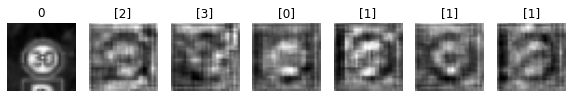

Epoch 521 g_loss= 0.7729975 d_loss= 0.67597824 real_acc= 0.72 fake_acc= 0.56
Epoch 522 g_loss= 0.7885976 d_loss= 0.6732058 real_acc= 0.68 fake_acc= 0.6
Epoch 523 g_loss= 0.7292143 d_loss= 0.65114385 real_acc= 0.78 fake_acc= 0.56
Epoch 524 g_loss= 0.6933969 d_loss= 0.689551 real_acc= 0.68 fake_acc= 0.52
Epoch 525 g_loss= 0.6659859 d_loss= 0.71631294 real_acc= 0.66 fake_acc= 0.38
Epoch 526 g_loss= 0.74029124 d_loss= 0.67307734 real_acc= 0.68 fake_acc= 0.56
Epoch 527 g_loss= 0.7124486 d_loss= 0.6535888 real_acc= 0.76 fake_acc= 0.52
Epoch 528 g_loss= 0.66722375 d_loss= 0.70846105 real_acc= 0.7 fake_acc= 0.4
Epoch 529 g_loss= 0.7152075 d_loss= 0.7183372 real_acc= 0.64 fake_acc= 0.5
Epoch 530 g_loss= 0.7740552 d_loss= 0.70256233 real_acc= 0.62 fake_acc= 0.58


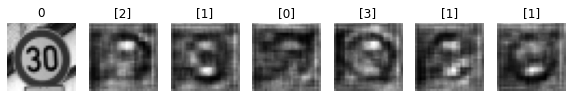

Epoch 531 g_loss= 0.777122 d_loss= 0.6699971 real_acc= 0.66 fake_acc= 0.6
Epoch 532 g_loss= 0.7908856 d_loss= 0.63444763 real_acc= 0.76 fake_acc= 0.56
Epoch 533 g_loss= 0.73021543 d_loss= 0.7253485 real_acc= 0.64 fake_acc= 0.48
Epoch 534 g_loss= 0.8184868 d_loss= 0.7109804 real_acc= 0.58 fake_acc= 0.66
Epoch 535 g_loss= 0.7081276 d_loss= 0.7244414 real_acc= 0.74 fake_acc= 0.48
Epoch 536 g_loss= 0.7754269 d_loss= 0.6792902 real_acc= 0.64 fake_acc= 0.62
Epoch 537 g_loss= 0.72439855 d_loss= 0.7120919 real_acc= 0.64 fake_acc= 0.46
Epoch 538 g_loss= 0.745794 d_loss= 0.637116 real_acc= 0.78 fake_acc= 0.52
Epoch 539 g_loss= 0.69342744 d_loss= 0.7006526 real_acc= 0.68 fake_acc= 0.44
Epoch 540 g_loss= 0.7420955 d_loss= 0.6730208 real_acc= 0.68 fake_acc= 0.64


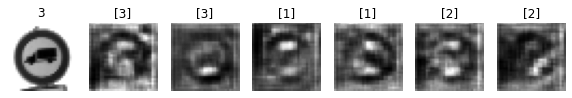

Epoch 541 g_loss= 0.7823476 d_loss= 0.63862574 real_acc= 0.76 fake_acc= 0.64
Epoch 542 g_loss= 0.659499 d_loss= 0.6880928 real_acc= 0.8 fake_acc= 0.42
Epoch 543 g_loss= 0.70002794 d_loss= 0.694505 real_acc= 0.7 fake_acc= 0.46
Epoch 544 g_loss= 0.7316148 d_loss= 0.6507907 real_acc= 0.8 fake_acc= 0.54
Epoch 545 g_loss= 0.68020934 d_loss= 0.6910416 real_acc= 0.8 fake_acc= 0.44
Epoch 546 g_loss= 0.70798934 d_loss= 0.68903273 real_acc= 0.7 fake_acc= 0.42
Epoch 547 g_loss= 0.70571345 d_loss= 0.65439785 real_acc= 0.82 fake_acc= 0.4
Epoch 548 g_loss= 0.7498741 d_loss= 0.6464351 real_acc= 0.76 fake_acc= 0.56
Epoch 549 g_loss= 0.7251876 d_loss= 0.6780604 real_acc= 0.72 fake_acc= 0.46
Epoch 550 g_loss= 0.77497745 d_loss= 0.6209146 real_acc= 0.8 fake_acc= 0.54


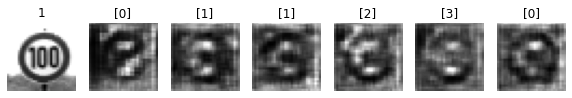

Epoch 551 g_loss= 0.7398477 d_loss= 0.65668714 real_acc= 0.74 fake_acc= 0.52
Epoch 552 g_loss= 0.68343866 d_loss= 0.6595298 real_acc= 0.82 fake_acc= 0.48
Epoch 553 g_loss= 0.7460971 d_loss= 0.6560739 real_acc= 0.7 fake_acc= 0.46
Epoch 554 g_loss= 0.8100841 d_loss= 0.62853634 real_acc= 0.74 fake_acc= 0.62
Epoch 555 g_loss= 0.7969768 d_loss= 0.6291379 real_acc= 0.8 fake_acc= 0.6
Epoch 556 g_loss= 0.77642304 d_loss= 0.6335976 real_acc= 0.8 fake_acc= 0.54
Epoch 557 g_loss= 0.74727494 d_loss= 0.65279806 real_acc= 0.74 fake_acc= 0.46
Epoch 558 g_loss= 0.7612719 d_loss= 0.65317595 real_acc= 0.74 fake_acc= 0.52
Epoch 559 g_loss= 0.72026503 d_loss= 0.682423 real_acc= 0.76 fake_acc= 0.46
Epoch 560 g_loss= 0.75656146 d_loss= 0.63653916 real_acc= 0.8 fake_acc= 0.52


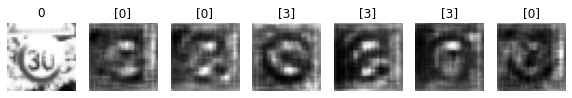

Epoch 561 g_loss= 0.76443994 d_loss= 0.6534902 real_acc= 0.7 fake_acc= 0.52
Epoch 562 g_loss= 0.85492915 d_loss= 0.6095199 real_acc= 0.78 fake_acc= 0.64
Epoch 563 g_loss= 0.81194824 d_loss= 0.61652637 real_acc= 0.84 fake_acc= 0.58
Epoch 564 g_loss= 0.7688354 d_loss= 0.63836837 real_acc= 0.8 fake_acc= 0.52
Epoch 565 g_loss= 0.7739748 d_loss= 0.63226163 real_acc= 0.82 fake_acc= 0.46
Epoch 566 g_loss= 0.83344233 d_loss= 0.6163074 real_acc= 0.74 fake_acc= 0.54
Epoch 567 g_loss= 0.7344295 d_loss= 0.63127565 real_acc= 0.8 fake_acc= 0.48
Epoch 568 g_loss= 0.81791055 d_loss= 0.6350232 real_acc= 0.82 fake_acc= 0.48
Epoch 569 g_loss= 0.7893478 d_loss= 0.65577894 real_acc= 0.7 fake_acc= 0.5
Epoch 570 g_loss= 0.8318907 d_loss= 0.59307224 real_acc= 0.88 fake_acc= 0.56


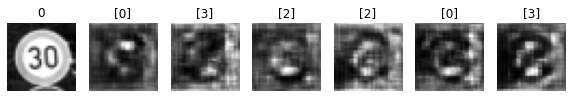

Epoch 571 g_loss= 0.8182257 d_loss= 0.6308178 real_acc= 0.68 fake_acc= 0.62
Epoch 572 g_loss= 0.8614102 d_loss= 0.6165035 real_acc= 0.72 fake_acc= 0.6
Epoch 573 g_loss= 0.7794073 d_loss= 0.63357997 real_acc= 0.78 fake_acc= 0.54
Epoch 574 g_loss= 0.845456 d_loss= 0.61204165 real_acc= 0.74 fake_acc= 0.54
Epoch 575 g_loss= 0.7549316 d_loss= 0.6550405 real_acc= 0.84 fake_acc= 0.44
Epoch 576 g_loss= 0.7387519 d_loss= 0.67869484 real_acc= 0.66 fake_acc= 0.46
Epoch 577 g_loss= 0.7675804 d_loss= 0.6591721 real_acc= 0.64 fake_acc= 0.46
Epoch 578 g_loss= 0.79442185 d_loss= 0.6233609 real_acc= 0.82 fake_acc= 0.52
Epoch 579 g_loss= 0.7944518 d_loss= 0.6154736 real_acc= 0.86 fake_acc= 0.48
Epoch 580 g_loss= 0.79882926 d_loss= 0.5955936 real_acc= 0.88 fake_acc= 0.58


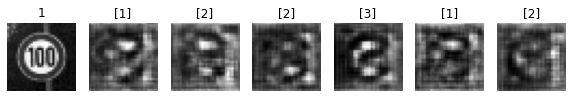

Epoch 581 g_loss= 0.8827412 d_loss= 0.55573756 real_acc= 0.9 fake_acc= 0.62
Epoch 582 g_loss= 0.8230902 d_loss= 0.61921126 real_acc= 0.8 fake_acc= 0.58
Epoch 583 g_loss= 0.83414316 d_loss= 0.6492653 real_acc= 0.74 fake_acc= 0.5
Epoch 584 g_loss= 0.77836454 d_loss= 0.61658186 real_acc= 0.86 fake_acc= 0.48
Epoch 585 g_loss= 0.76892436 d_loss= 0.62642175 real_acc= 0.76 fake_acc= 0.44
Epoch 586 g_loss= 0.80927247 d_loss= 0.6740955 real_acc= 0.66 fake_acc= 0.48
Epoch 587 g_loss= 0.959723 d_loss= 0.6007409 real_acc= 0.76 fake_acc= 0.7
Epoch 588 g_loss= 0.832602 d_loss= 0.60144675 real_acc= 0.82 fake_acc= 0.54
Epoch 589 g_loss= 0.8593718 d_loss= 0.5995884 real_acc= 0.8 fake_acc= 0.66
Epoch 590 g_loss= 0.80160743 d_loss= 0.6483815 real_acc= 0.8 fake_acc= 0.46


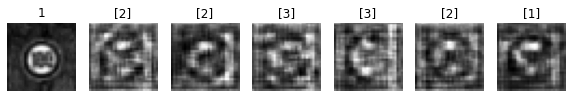

Epoch 591 g_loss= 0.9126036 d_loss= 0.60693467 real_acc= 0.72 fake_acc= 0.64
Epoch 592 g_loss= 0.9362115 d_loss= 0.57830405 real_acc= 0.76 fake_acc= 0.68
Epoch 593 g_loss= 0.8987314 d_loss= 0.5959891 real_acc= 0.76 fake_acc= 0.62
Epoch 594 g_loss= 0.89129066 d_loss= 0.5904753 real_acc= 0.78 fake_acc= 0.6
Epoch 595 g_loss= 0.8039875 d_loss= 0.6484879 real_acc= 0.76 fake_acc= 0.52
Epoch 596 g_loss= 0.84566194 d_loss= 0.58201754 real_acc= 0.86 fake_acc= 0.5
Epoch 597 g_loss= 0.8142844 d_loss= 0.6562377 real_acc= 0.72 fake_acc= 0.5
Epoch 598 g_loss= 0.8089234 d_loss= 0.65444326 real_acc= 0.84 fake_acc= 0.44
Epoch 599 g_loss= 0.85586447 d_loss= 0.60615504 real_acc= 0.84 fake_acc= 0.5
Epoch 600 g_loss= 0.82742065 d_loss= 0.66202235 real_acc= 0.72 fake_acc= 0.44


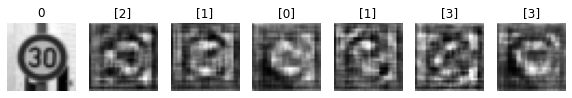

Epoch 601 g_loss= 0.8311388 d_loss= 0.63333505 real_acc= 0.74 fake_acc= 0.52
Epoch 602 g_loss= 0.7866626 d_loss= 0.65152735 real_acc= 0.76 fake_acc= 0.42
Epoch 603 g_loss= 0.8730246 d_loss= 0.67072165 real_acc= 0.66 fake_acc= 0.56
Epoch 604 g_loss= 0.86802673 d_loss= 0.66602623 real_acc= 0.6 fake_acc= 0.5
Epoch 605 g_loss= 0.84384847 d_loss= 0.659426 real_acc= 0.62 fake_acc= 0.56
Epoch 606 g_loss= 0.9138834 d_loss= 0.62792134 real_acc= 0.58 fake_acc= 0.64
Epoch 607 g_loss= 0.86503685 d_loss= 0.6401413 real_acc= 0.68 fake_acc= 0.5
Epoch 608 g_loss= 0.87285155 d_loss= 0.63027227 real_acc= 0.76 fake_acc= 0.6
Epoch 609 g_loss= 0.84975755 d_loss= 0.63477397 real_acc= 0.74 fake_acc= 0.6
Epoch 610 g_loss= 0.8842673 d_loss= 0.5893033 real_acc= 0.84 fake_acc= 0.6


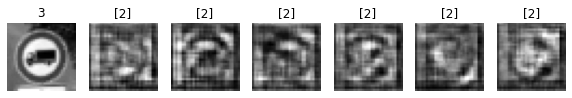

Epoch 611 g_loss= 0.87738234 d_loss= 0.6294792 real_acc= 0.72 fake_acc= 0.64
Epoch 612 g_loss= 0.83241224 d_loss= 0.62502766 real_acc= 0.72 fake_acc= 0.56
Epoch 613 g_loss= 0.77499884 d_loss= 0.66973686 real_acc= 0.72 fake_acc= 0.54
Epoch 614 g_loss= 0.82740766 d_loss= 0.65289253 real_acc= 0.74 fake_acc= 0.54
Epoch 615 g_loss= 0.8057063 d_loss= 0.6461556 real_acc= 0.72 fake_acc= 0.56
Epoch 616 g_loss= 0.75446725 d_loss= 0.6373018 real_acc= 0.8 fake_acc= 0.46
Epoch 617 g_loss= 0.8472879 d_loss= 0.6413643 real_acc= 0.7 fake_acc= 0.52
Epoch 618 g_loss= 0.8989553 d_loss= 0.6500963 real_acc= 0.66 fake_acc= 0.58
Epoch 619 g_loss= 0.86866087 d_loss= 0.6314882 real_acc= 0.66 fake_acc= 0.6
Epoch 620 g_loss= 0.9409511 d_loss= 0.6508299 real_acc= 0.56 fake_acc= 0.62


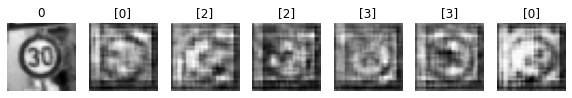

Epoch 621 g_loss= 1.0222892 d_loss= 0.6257193 real_acc= 0.48 fake_acc= 0.74
Epoch 622 g_loss= 0.80059624 d_loss= 0.6558949 real_acc= 0.66 fake_acc= 0.56
Epoch 623 g_loss= 0.90664446 d_loss= 0.63691056 real_acc= 0.62 fake_acc= 0.6
Epoch 624 g_loss= 0.91447365 d_loss= 0.63802636 real_acc= 0.58 fake_acc= 0.64
Epoch 625 g_loss= 0.83391356 d_loss= 0.6455394 real_acc= 0.7 fake_acc= 0.52
Epoch 626 g_loss= 0.854204 d_loss= 0.6687733 real_acc= 0.62 fake_acc= 0.52
Epoch 627 g_loss= 0.90594846 d_loss= 0.62067354 real_acc= 0.64 fake_acc= 0.68
Epoch 628 g_loss= 0.8556127 d_loss= 0.6803104 real_acc= 0.6 fake_acc= 0.64
Epoch 629 g_loss= 0.8560227 d_loss= 0.64707994 real_acc= 0.7 fake_acc= 0.54
Epoch 630 g_loss= 0.8090923 d_loss= 0.66197896 real_acc= 0.66 fake_acc= 0.42


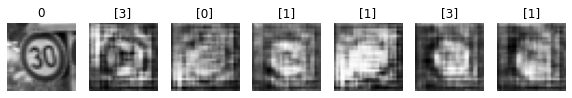

Epoch 631 g_loss= 0.90481085 d_loss= 0.5998745 real_acc= 0.8 fake_acc= 0.62
Epoch 632 g_loss= 0.895338 d_loss= 0.6031501 real_acc= 0.8 fake_acc= 0.66
Epoch 633 g_loss= 0.9373389 d_loss= 0.58260846 real_acc= 0.74 fake_acc= 0.74
Epoch 634 g_loss= 0.9606198 d_loss= 0.6404652 real_acc= 0.48 fake_acc= 0.76
Epoch 635 g_loss= 0.9828197 d_loss= 0.59294564 real_acc= 0.64 fake_acc= 0.78
Epoch 636 g_loss= 0.9400234 d_loss= 0.56941426 real_acc= 0.8 fake_acc= 0.72
Epoch 637 g_loss= 0.8257623 d_loss= 0.6422566 real_acc= 0.74 fake_acc= 0.54
Epoch 638 g_loss= 0.80423063 d_loss= 0.67417395 real_acc= 0.6 fake_acc= 0.46
Epoch 639 g_loss= 0.81649584 d_loss= 0.63675654 real_acc= 0.82 fake_acc= 0.54
Epoch 640 g_loss= 0.88214636 d_loss= 0.6235232 real_acc= 0.78 fake_acc= 0.6


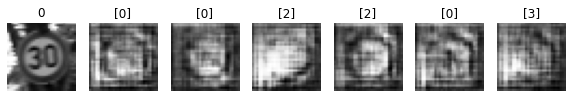

Epoch 641 g_loss= 0.82104766 d_loss= 0.6689833 real_acc= 0.7 fake_acc= 0.54
Epoch 642 g_loss= 0.91246283 d_loss= 0.6328213 real_acc= 0.76 fake_acc= 0.58
Epoch 643 g_loss= 0.8375399 d_loss= 0.63121045 real_acc= 0.66 fake_acc= 0.54
Epoch 644 g_loss= 0.8746125 d_loss= 0.6393216 real_acc= 0.66 fake_acc= 0.56
Epoch 645 g_loss= 0.9102372 d_loss= 0.6299498 real_acc= 0.68 fake_acc= 0.6
Epoch 646 g_loss= 0.8562612 d_loss= 0.61996686 real_acc= 0.76 fake_acc= 0.56
Epoch 647 g_loss= 0.95614606 d_loss= 0.59303117 real_acc= 0.68 fake_acc= 0.66
Epoch 648 g_loss= 0.9104459 d_loss= 0.6369645 real_acc= 0.66 fake_acc= 0.66
Epoch 649 g_loss= 0.85888106 d_loss= 0.65749216 real_acc= 0.72 fake_acc= 0.5
Epoch 650 g_loss= 0.8766101 d_loss= 0.67741966 real_acc= 0.6 fake_acc= 0.62


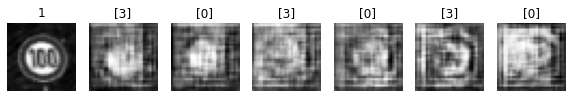

Epoch 651 g_loss= 0.8402302 d_loss= 0.6710203 real_acc= 0.66 fake_acc= 0.56
Epoch 652 g_loss= 0.8947979 d_loss= 0.63055784 real_acc= 0.66 fake_acc= 0.6
Epoch 653 g_loss= 0.92155325 d_loss= 0.5845554 real_acc= 0.8 fake_acc= 0.58
Epoch 654 g_loss= 0.8405088 d_loss= 0.63173926 real_acc= 0.74 fake_acc= 0.54
Epoch 655 g_loss= 0.87476057 d_loss= 0.62070155 real_acc= 0.78 fake_acc= 0.6
Epoch 656 g_loss= 0.8550519 d_loss= 0.6531595 real_acc= 0.66 fake_acc= 0.58
Epoch 657 g_loss= 0.9526511 d_loss= 0.6581789 real_acc= 0.66 fake_acc= 0.64
Epoch 658 g_loss= 0.8564216 d_loss= 0.67818844 real_acc= 0.64 fake_acc= 0.54
Epoch 659 g_loss= 0.80602354 d_loss= 0.6265694 real_acc= 0.74 fake_acc= 0.48
Epoch 660 g_loss= 0.91044897 d_loss= 0.61813813 real_acc= 0.74 fake_acc= 0.6


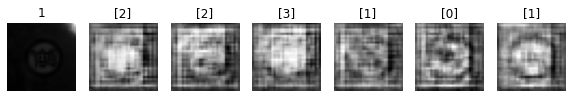

Epoch 661 g_loss= 0.75937575 d_loss= 0.6641743 real_acc= 0.7 fake_acc= 0.36
Epoch 662 g_loss= 0.82434046 d_loss= 0.6136099 real_acc= 0.8 fake_acc= 0.48
Epoch 663 g_loss= 0.9077386 d_loss= 0.60339004 real_acc= 0.78 fake_acc= 0.6
Epoch 664 g_loss= 0.86745536 d_loss= 0.6319654 real_acc= 0.7 fake_acc= 0.6
Epoch 665 g_loss= 0.8255083 d_loss= 0.6303201 real_acc= 0.72 fake_acc= 0.5
Epoch 666 g_loss= 0.863955 d_loss= 0.6258364 real_acc= 0.76 fake_acc= 0.5
Epoch 667 g_loss= 0.78998953 d_loss= 0.65554476 real_acc= 0.76 fake_acc= 0.46
Epoch 668 g_loss= 0.85461396 d_loss= 0.6489663 real_acc= 0.58 fake_acc= 0.54
Epoch 669 g_loss= 0.85336816 d_loss= 0.64695895 real_acc= 0.72 fake_acc= 0.56
Epoch 670 g_loss= 0.8996633 d_loss= 0.6133065 real_acc= 0.8 fake_acc= 0.6


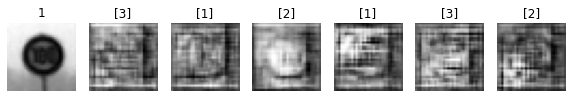

Epoch 671 g_loss= 1.0127754 d_loss= 0.6048544 real_acc= 0.66 fake_acc= 0.82
Epoch 672 g_loss= 0.92175674 d_loss= 0.6299797 real_acc= 0.6 fake_acc= 0.62
Epoch 673 g_loss= 0.82201874 d_loss= 0.649132 real_acc= 0.8 fake_acc= 0.52
Epoch 674 g_loss= 0.8761108 d_loss= 0.60376453 real_acc= 0.8 fake_acc= 0.52
Epoch 675 g_loss= 0.8899702 d_loss= 0.6124859 real_acc= 0.78 fake_acc= 0.52
Epoch 676 g_loss= 0.8229419 d_loss= 0.6220014 real_acc= 0.82 fake_acc= 0.46
Epoch 677 g_loss= 0.83062065 d_loss= 0.65601134 real_acc= 0.7 fake_acc= 0.56
Epoch 678 g_loss= 0.8195758 d_loss= 0.60894215 real_acc= 0.78 fake_acc= 0.52
Epoch 679 g_loss= 0.85220265 d_loss= 0.6315458 real_acc= 0.78 fake_acc= 0.52
Epoch 680 g_loss= 0.8784819 d_loss= 0.5820932 real_acc= 0.9 fake_acc= 0.58


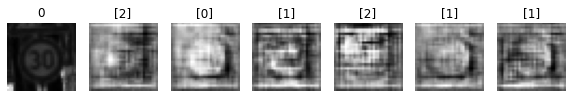

Epoch 681 g_loss= 0.83664185 d_loss= 0.66076416 real_acc= 0.7 fake_acc= 0.46
Epoch 682 g_loss= 0.83671737 d_loss= 0.6249114 real_acc= 0.76 fake_acc= 0.54
Epoch 683 g_loss= 0.8970053 d_loss= 0.6228338 real_acc= 0.66 fake_acc= 0.6
Epoch 684 g_loss= 0.88910604 d_loss= 0.60981095 real_acc= 0.78 fake_acc= 0.56
Epoch 685 g_loss= 0.8437342 d_loss= 0.62483263 real_acc= 0.76 fake_acc= 0.54
Epoch 686 g_loss= 0.92375284 d_loss= 0.5875759 real_acc= 0.8 fake_acc= 0.66
Epoch 687 g_loss= 0.90697646 d_loss= 0.62289953 real_acc= 0.64 fake_acc= 0.6
Epoch 688 g_loss= 0.76876277 d_loss= 0.6545609 real_acc= 0.76 fake_acc= 0.42
Epoch 689 g_loss= 0.89390993 d_loss= 0.61843836 real_acc= 0.76 fake_acc= 0.54
Epoch 690 g_loss= 0.9217839 d_loss= 0.5934491 real_acc= 0.78 fake_acc= 0.66


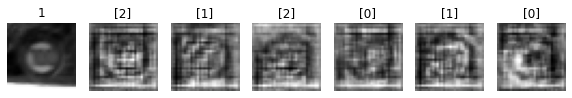

Epoch 691 g_loss= 0.9059276 d_loss= 0.61636734 real_acc= 0.68 fake_acc= 0.54
Epoch 692 g_loss= 0.8094441 d_loss= 0.6310339 real_acc= 0.78 fake_acc= 0.52
Epoch 693 g_loss= 0.8580704 d_loss= 0.6326039 real_acc= 0.76 fake_acc= 0.5
Epoch 694 g_loss= 0.8422621 d_loss= 0.62560916 real_acc= 0.78 fake_acc= 0.5
Epoch 695 g_loss= 0.81876534 d_loss= 0.6449016 real_acc= 0.76 fake_acc= 0.52
Epoch 696 g_loss= 0.8441931 d_loss= 0.61695033 real_acc= 0.76 fake_acc= 0.56
Epoch 697 g_loss= 0.78566587 d_loss= 0.6596942 real_acc= 0.7 fake_acc= 0.46
Epoch 698 g_loss= 0.80614984 d_loss= 0.6572883 real_acc= 0.72 fake_acc= 0.44
Epoch 699 g_loss= 0.8882285 d_loss= 0.59989 real_acc= 0.7 fake_acc= 0.64
Epoch 700 g_loss= 0.75620246 d_loss= 0.631317 real_acc= 0.78 fake_acc= 0.46


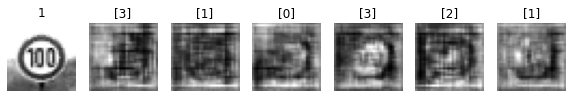

Epoch 701 g_loss= 0.8192801 d_loss= 0.59656847 real_acc= 0.8 fake_acc= 0.56
Epoch 702 g_loss= 0.84964067 d_loss= 0.63985026 real_acc= 0.72 fake_acc= 0.58
Epoch 703 g_loss= 0.86449385 d_loss= 0.5810218 real_acc= 0.86 fake_acc= 0.58
Epoch 704 g_loss= 0.9451831 d_loss= 0.571725 real_acc= 0.76 fake_acc= 0.68
Epoch 705 g_loss= 0.79160094 d_loss= 0.6353518 real_acc= 0.82 fake_acc= 0.44
Epoch 706 g_loss= 0.83679426 d_loss= 0.6610496 real_acc= 0.64 fake_acc= 0.54
Epoch 707 g_loss= 0.81861407 d_loss= 0.65298915 real_acc= 0.7 fake_acc= 0.5
Epoch 708 g_loss= 0.80149734 d_loss= 0.6824691 real_acc= 0.66 fake_acc= 0.46
Epoch 709 g_loss= 0.85738736 d_loss= 0.6001163 real_acc= 0.7 fake_acc= 0.56
Epoch 710 g_loss= 0.80811554 d_loss= 0.6053066 real_acc= 0.78 fake_acc= 0.46


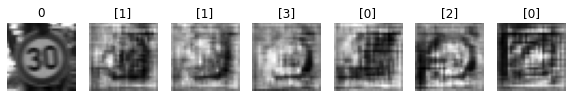

Epoch 711 g_loss= 0.78160936 d_loss= 0.64764273 real_acc= 0.7 fake_acc= 0.48
Epoch 712 g_loss= 0.8513173 d_loss= 0.57630277 real_acc= 0.84 fake_acc= 0.62
Epoch 713 g_loss= 0.83316046 d_loss= 0.6099235 real_acc= 0.76 fake_acc= 0.52
Epoch 714 g_loss= 0.8062063 d_loss= 0.61816597 real_acc= 0.78 fake_acc= 0.48
Epoch 715 g_loss= 0.807066 d_loss= 0.6362997 real_acc= 0.76 fake_acc= 0.46
Epoch 716 g_loss= 0.84011215 d_loss= 0.62574506 real_acc= 0.7 fake_acc= 0.58
Epoch 717 g_loss= 0.8491981 d_loss= 0.5915595 real_acc= 0.78 fake_acc= 0.58
Epoch 718 g_loss= 0.8136047 d_loss= 0.5890118 real_acc= 0.86 fake_acc= 0.46
Epoch 719 g_loss= 0.77388483 d_loss= 0.6406517 real_acc= 0.74 fake_acc= 0.44
Epoch 720 g_loss= 0.84851956 d_loss= 0.6316528 real_acc= 0.64 fake_acc= 0.64


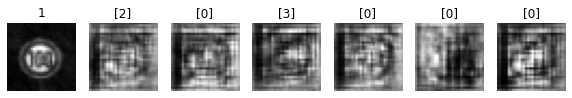

Epoch 721 g_loss= 0.7650108 d_loss= 0.68367875 real_acc= 0.64 fake_acc= 0.42
Epoch 722 g_loss= 0.91136026 d_loss= 0.6152972 real_acc= 0.68 fake_acc= 0.54
Epoch 723 g_loss= 0.8514426 d_loss= 0.600096 real_acc= 0.74 fake_acc= 0.58
Epoch 724 g_loss= 0.84975946 d_loss= 0.56816155 real_acc= 0.88 fake_acc= 0.56
Epoch 725 g_loss= 0.8243675 d_loss= 0.615602 real_acc= 0.7 fake_acc= 0.6
Epoch 726 g_loss= 0.81148344 d_loss= 0.58417416 real_acc= 0.9 fake_acc= 0.54
Epoch 727 g_loss= 0.7812051 d_loss= 0.6114676 real_acc= 0.82 fake_acc= 0.46
Epoch 728 g_loss= 0.8398677 d_loss= 0.6087322 real_acc= 0.76 fake_acc= 0.56
Epoch 729 g_loss= 0.83131623 d_loss= 0.63286555 real_acc= 0.72 fake_acc= 0.52
Epoch 730 g_loss= 0.8091023 d_loss= 0.6017794 real_acc= 0.82 fake_acc= 0.54


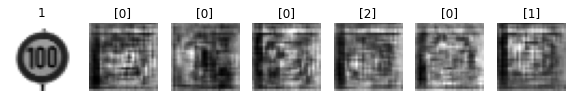

Epoch 731 g_loss= 0.8259244 d_loss= 0.6121509 real_acc= 0.8 fake_acc= 0.52
Epoch 732 g_loss= 0.8182071 d_loss= 0.6168356 real_acc= 0.74 fake_acc= 0.6
Epoch 733 g_loss= 0.8782938 d_loss= 0.6425916 real_acc= 0.66 fake_acc= 0.62
Epoch 734 g_loss= 0.78800875 d_loss= 0.66418886 real_acc= 0.62 fake_acc= 0.5
Epoch 735 g_loss= 0.85933167 d_loss= 0.57539153 real_acc= 0.86 fake_acc= 0.66
Epoch 736 g_loss= 0.7716656 d_loss= 0.6173333 real_acc= 0.82 fake_acc= 0.48
Epoch 737 g_loss= 0.8730714 d_loss= 0.6033863 real_acc= 0.76 fake_acc= 0.7
Epoch 738 g_loss= 0.79810643 d_loss= 0.633047 real_acc= 0.76 fake_acc= 0.5
Epoch 739 g_loss= 0.8823959 d_loss= 0.59463096 real_acc= 0.76 fake_acc= 0.66
Epoch 740 g_loss= 0.8565712 d_loss= 0.6442132 real_acc= 0.7 fake_acc= 0.6


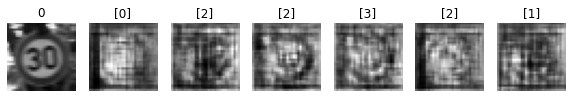

Epoch 741 g_loss= 0.8774681 d_loss= 0.65386885 real_acc= 0.62 fake_acc= 0.64
Epoch 742 g_loss= 0.8610957 d_loss= 0.6456446 real_acc= 0.62 fake_acc= 0.58
Epoch 743 g_loss= 0.933552 d_loss= 0.6016266 real_acc= 0.76 fake_acc= 0.66
Epoch 744 g_loss= 0.873135 d_loss= 0.62779224 real_acc= 0.76 fake_acc= 0.56
Epoch 745 g_loss= 0.83981234 d_loss= 0.6284827 real_acc= 0.78 fake_acc= 0.64
Epoch 746 g_loss= 0.90700746 d_loss= 0.6175431 real_acc= 0.6 fake_acc= 0.66
Epoch 747 g_loss= 0.79928374 d_loss= 0.61891603 real_acc= 0.78 fake_acc= 0.48
Epoch 748 g_loss= 0.7754448 d_loss= 0.66552156 real_acc= 0.62 fake_acc= 0.46
Epoch 749 g_loss= 0.8460472 d_loss= 0.6318048 real_acc= 0.7 fake_acc= 0.58
Epoch 750 g_loss= 0.9377984 d_loss= 0.6030535 real_acc= 0.66 fake_acc= 0.72


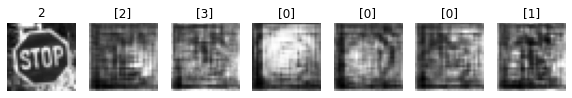

Epoch 751 g_loss= 0.9078702 d_loss= 0.56226134 real_acc= 0.8 fake_acc= 0.62
Epoch 752 g_loss= 0.958223 d_loss= 0.6146253 real_acc= 0.66 fake_acc= 0.66
Epoch 753 g_loss= 0.8476437 d_loss= 0.6113627 real_acc= 0.76 fake_acc= 0.58
Epoch 754 g_loss= 0.83610153 d_loss= 0.64063615 real_acc= 0.66 fake_acc= 0.56
Epoch 755 g_loss= 0.9360589 d_loss= 0.6049759 real_acc= 0.64 fake_acc= 0.66
Epoch 756 g_loss= 0.9382349 d_loss= 0.5914471 real_acc= 0.62 fake_acc= 0.7
Epoch 757 g_loss= 0.9920978 d_loss= 0.59548247 real_acc= 0.7 fake_acc= 0.74
Epoch 758 g_loss= 0.9215419 d_loss= 0.61089915 real_acc= 0.72 fake_acc= 0.6
Epoch 759 g_loss= 0.93861544 d_loss= 0.60577226 real_acc= 0.66 fake_acc= 0.6
Epoch 760 g_loss= 0.9622781 d_loss= 0.62945044 real_acc= 0.68 fake_acc= 0.7


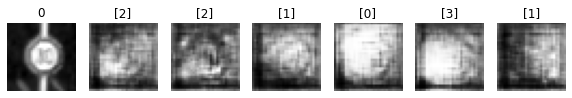

Epoch 761 g_loss= 0.9084794 d_loss= 0.59798276 real_acc= 0.7 fake_acc= 0.58
Epoch 762 g_loss= 0.9536853 d_loss= 0.57031035 real_acc= 0.74 fake_acc= 0.68
Epoch 763 g_loss= 0.8241684 d_loss= 0.6758709 real_acc= 0.62 fake_acc= 0.5
Epoch 764 g_loss= 0.9513118 d_loss= 0.6602204 real_acc= 0.62 fake_acc= 0.64
Epoch 765 g_loss= 0.8570717 d_loss= 0.6375139 real_acc= 0.74 fake_acc= 0.58
Epoch 766 g_loss= 0.8591945 d_loss= 0.68023205 real_acc= 0.64 fake_acc= 0.52
Epoch 767 g_loss= 0.90825546 d_loss= 0.6737325 real_acc= 0.62 fake_acc= 0.66
Epoch 768 g_loss= 0.9736812 d_loss= 0.70918703 real_acc= 0.48 fake_acc= 0.64
Epoch 769 g_loss= 1.1041553 d_loss= 0.64058614 real_acc= 0.66 fake_acc= 0.74
Epoch 770 g_loss= 0.9610118 d_loss= 0.6377796 real_acc= 0.64 fake_acc= 0.6


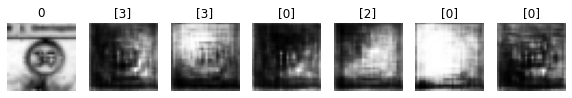

Epoch 771 g_loss= 0.79068756 d_loss= 0.72060287 real_acc= 0.62 fake_acc= 0.48
Epoch 772 g_loss= 0.80855596 d_loss= 0.67972 real_acc= 0.66 fake_acc= 0.56
Epoch 773 g_loss= 0.75494266 d_loss= 0.69711995 real_acc= 0.7 fake_acc= 0.46
Epoch 774 g_loss= 0.9271123 d_loss= 0.6299653 real_acc= 0.7 fake_acc= 0.64
Epoch 775 g_loss= 0.8949309 d_loss= 0.59677875 real_acc= 0.7 fake_acc= 0.58
Epoch 776 g_loss= 0.7800012 d_loss= 0.68180823 real_acc= 0.72 fake_acc= 0.56
Epoch 777 g_loss= 0.8050147 d_loss= 0.6809896 real_acc= 0.7 fake_acc= 0.5
Epoch 778 g_loss= 0.82587564 d_loss= 0.6882385 real_acc= 0.66 fake_acc= 0.52
Epoch 779 g_loss= 0.9623813 d_loss= 0.6072687 real_acc= 0.66 fake_acc= 0.64
Epoch 780 g_loss= 0.88144684 d_loss= 0.66452664 real_acc= 0.56 fake_acc= 0.6


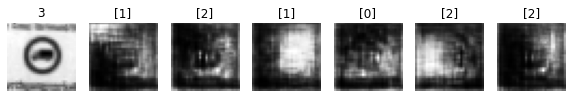

Epoch 781 g_loss= 0.8797401 d_loss= 0.67323136 real_acc= 0.54 fake_acc= 0.58
Epoch 782 g_loss= 0.99752015 d_loss= 0.61312795 real_acc= 0.58 fake_acc= 0.7
Epoch 783 g_loss= 0.91831666 d_loss= 0.65825534 real_acc= 0.62 fake_acc= 0.66
Epoch 784 g_loss= 0.89887613 d_loss= 0.65406835 real_acc= 0.64 fake_acc= 0.62
Epoch 785 g_loss= 1.1014938 d_loss= 0.5498421 real_acc= 0.7 fake_acc= 0.8
Epoch 786 g_loss= 0.98637724 d_loss= 0.6156054 real_acc= 0.62 fake_acc= 0.68
Epoch 787 g_loss= 0.94659024 d_loss= 0.629527 real_acc= 0.56 fake_acc= 0.74
Epoch 788 g_loss= 0.9878145 d_loss= 0.6176444 real_acc= 0.58 fake_acc= 0.66
Epoch 789 g_loss= 0.96430284 d_loss= 0.6253679 real_acc= 0.58 fake_acc= 0.7
Epoch 790 g_loss= 0.91358095 d_loss= 0.6214603 real_acc= 0.66 fake_acc= 0.62


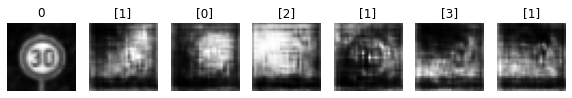

Epoch 791 g_loss= 0.8887297 d_loss= 0.595801 real_acc= 0.78 fake_acc= 0.62
Epoch 792 g_loss= 0.8883905 d_loss= 0.6294104 real_acc= 0.7 fake_acc= 0.58
Epoch 793 g_loss= 0.8686085 d_loss= 0.5950203 real_acc= 0.72 fake_acc= 0.62
Epoch 794 g_loss= 0.7952881 d_loss= 0.64106554 real_acc= 0.74 fake_acc= 0.5
Epoch 795 g_loss= 0.86747545 d_loss= 0.6418427 real_acc= 0.66 fake_acc= 0.52
Epoch 796 g_loss= 0.9413722 d_loss= 0.58272123 real_acc= 0.74 fake_acc= 0.68
Epoch 797 g_loss= 0.90571684 d_loss= 0.58405286 real_acc= 0.78 fake_acc= 0.66
Epoch 798 g_loss= 0.8415217 d_loss= 0.6013293 real_acc= 0.82 fake_acc= 0.52
Epoch 799 g_loss= 0.9154873 d_loss= 0.57904613 real_acc= 0.74 fake_acc= 0.66
Epoch 800 g_loss= 0.8767081 d_loss= 0.6360407 real_acc= 0.62 fake_acc= 0.56


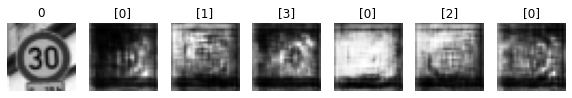

Epoch 801 g_loss= 0.9496147 d_loss= 0.6117571 real_acc= 0.64 fake_acc= 0.68
Epoch 802 g_loss= 0.921336 d_loss= 0.6208997 real_acc= 0.66 fake_acc= 0.64
Epoch 803 g_loss= 0.86828506 d_loss= 0.6539287 real_acc= 0.66 fake_acc= 0.54
Epoch 804 g_loss= 0.9723759 d_loss= 0.57905066 real_acc= 0.8 fake_acc= 0.62
Epoch 805 g_loss= 0.8801466 d_loss= 0.5985733 real_acc= 0.78 fake_acc= 0.56
Epoch 806 g_loss= 0.88261586 d_loss= 0.6321576 real_acc= 0.72 fake_acc= 0.58
Epoch 807 g_loss= 0.87919694 d_loss= 0.64262766 real_acc= 0.72 fake_acc= 0.62
Epoch 808 g_loss= 0.8441486 d_loss= 0.604149 real_acc= 0.78 fake_acc= 0.56
Epoch 809 g_loss= 0.9416958 d_loss= 0.5733198 real_acc= 0.74 fake_acc= 0.66
Epoch 810 g_loss= 0.8136221 d_loss= 0.6181513 real_acc= 0.8 fake_acc= 0.48


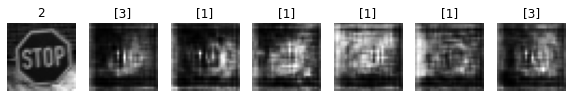

Epoch 811 g_loss= 0.7820344 d_loss= 0.6411756 real_acc= 0.76 fake_acc= 0.46
Epoch 812 g_loss= 0.8451086 d_loss= 0.5991024 real_acc= 0.8 fake_acc= 0.58
Epoch 813 g_loss= 0.84154075 d_loss= 0.60049236 real_acc= 0.76 fake_acc= 0.58
Epoch 814 g_loss= 0.9160872 d_loss= 0.6005974 real_acc= 0.76 fake_acc= 0.6
Epoch 815 g_loss= 0.83762133 d_loss= 0.5857523 real_acc= 0.84 fake_acc= 0.6
Epoch 816 g_loss= 0.7856873 d_loss= 0.6271584 real_acc= 0.76 fake_acc= 0.5
Epoch 817 g_loss= 0.71839935 d_loss= 0.66556364 real_acc= 0.74 fake_acc= 0.4
Epoch 818 g_loss= 0.7762367 d_loss= 0.61430395 real_acc= 0.82 fake_acc= 0.52
Epoch 819 g_loss= 0.7172756 d_loss= 0.6163951 real_acc= 0.88 fake_acc= 0.48
Epoch 820 g_loss= 0.72365576 d_loss= 0.67928374 real_acc= 0.68 fake_acc= 0.46


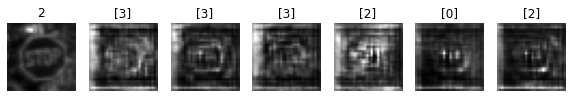

Epoch 821 g_loss= 0.70373225 d_loss= 0.6712322 real_acc= 0.8 fake_acc= 0.46
Epoch 822 g_loss= 0.7337363 d_loss= 0.6480088 real_acc= 0.78 fake_acc= 0.48
Epoch 823 g_loss= 0.683954 d_loss= 0.7200474 real_acc= 0.72 fake_acc= 0.36
Epoch 824 g_loss= 0.73094314 d_loss= 0.66448593 real_acc= 0.7 fake_acc= 0.42
Epoch 825 g_loss= 0.762467 d_loss= 0.6810714 real_acc= 0.62 fake_acc= 0.42
Epoch 826 g_loss= 0.76029783 d_loss= 0.70149314 real_acc= 0.58 fake_acc= 0.5
Epoch 827 g_loss= 0.78476286 d_loss= 0.6457133 real_acc= 0.72 fake_acc= 0.6
Epoch 828 g_loss= 0.73608804 d_loss= 0.6714858 real_acc= 0.72 fake_acc= 0.48
Epoch 829 g_loss= 0.7363339 d_loss= 0.6956121 real_acc= 0.58 fake_acc= 0.54
Epoch 830 g_loss= 0.6845526 d_loss= 0.6982764 real_acc= 0.64 fake_acc= 0.42


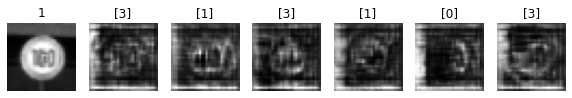

Epoch 831 g_loss= 0.6970665 d_loss= 0.65591574 real_acc= 0.78 fake_acc= 0.5
Epoch 832 g_loss= 0.6646818 d_loss= 0.66217417 real_acc= 0.84 fake_acc= 0.44
Epoch 833 g_loss= 0.652169 d_loss= 0.7013488 real_acc= 0.76 fake_acc= 0.44
Epoch 834 g_loss= 0.671438 d_loss= 0.6823537 real_acc= 0.72 fake_acc= 0.5
Epoch 835 g_loss= 0.6732799 d_loss= 0.65807045 real_acc= 0.7 fake_acc= 0.46
Epoch 836 g_loss= 0.70730424 d_loss= 0.65190697 real_acc= 0.68 fake_acc= 0.54
Epoch 837 g_loss= 0.7190228 d_loss= 0.6519593 real_acc= 0.72 fake_acc= 0.52
Epoch 838 g_loss= 0.7137291 d_loss= 0.6809033 real_acc= 0.64 fake_acc= 0.44
Epoch 839 g_loss= 0.801941 d_loss= 0.6706362 real_acc= 0.52 fake_acc= 0.58
Epoch 840 g_loss= 0.8003948 d_loss= 0.6443231 real_acc= 0.56 fake_acc= 0.52


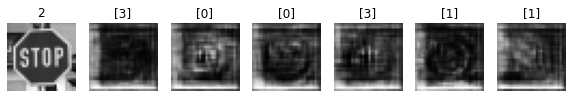

Epoch 841 g_loss= 0.87346697 d_loss= 0.6484057 real_acc= 0.4 fake_acc= 0.68
Epoch 842 g_loss= 0.8919548 d_loss= 0.6434319 real_acc= 0.42 fake_acc= 0.62
Epoch 843 g_loss= 0.87010485 d_loss= 0.6296328 real_acc= 0.54 fake_acc= 0.68
Epoch 844 g_loss= 0.8772414 d_loss= 0.6405468 real_acc= 0.44 fake_acc= 0.58
Epoch 845 g_loss= 0.86393493 d_loss= 0.58743083 real_acc= 0.68 fake_acc= 0.64
Epoch 846 g_loss= 0.8813582 d_loss= 0.6073782 real_acc= 0.56 fake_acc= 0.54
Epoch 847 g_loss= 0.82489264 d_loss= 0.6083088 real_acc= 0.58 fake_acc= 0.56
Epoch 848 g_loss= 0.87152314 d_loss= 0.58961344 real_acc= 0.7 fake_acc= 0.56
Epoch 849 g_loss= 0.9033899 d_loss= 0.5391408 real_acc= 0.78 fake_acc= 0.64
Epoch 850 g_loss= 0.8628422 d_loss= 0.5668179 real_acc= 0.7 fake_acc= 0.6


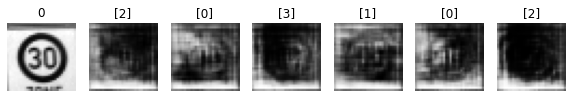

Epoch 851 g_loss= 0.9361564 d_loss= 0.6131377 real_acc= 0.58 fake_acc= 0.64
Epoch 852 g_loss= 0.8956076 d_loss= 0.60963345 real_acc= 0.62 fake_acc= 0.54
Epoch 853 g_loss= 0.93954116 d_loss= 0.56415415 real_acc= 0.7 fake_acc= 0.6
Epoch 854 g_loss= 0.9496038 d_loss= 0.5795909 real_acc= 0.66 fake_acc= 0.66
Epoch 855 g_loss= 1.027564 d_loss= 0.5456092 real_acc= 0.72 fake_acc= 0.7
Epoch 856 g_loss= 1.0690186 d_loss= 0.5820886 real_acc= 0.64 fake_acc= 0.7
Epoch 857 g_loss= 1.1462299 d_loss= 0.5718934 real_acc= 0.74 fake_acc= 0.84
Epoch 858 g_loss= 1.1194453 d_loss= 0.55467725 real_acc= 0.62 fake_acc= 0.74
Epoch 859 g_loss= 1.2202997 d_loss= 0.5440528 real_acc= 0.68 fake_acc= 0.82
Epoch 860 g_loss= 1.2437438 d_loss= 0.48954472 real_acc= 0.82 fake_acc= 0.8


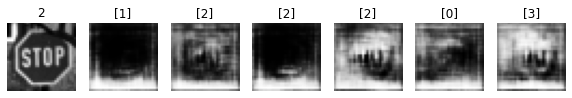

Epoch 861 g_loss= 1.1481252 d_loss= 0.53409237 real_acc= 0.82 fake_acc= 0.78
Epoch 862 g_loss= 1.1613061 d_loss= 0.57437146 real_acc= 0.74 fake_acc= 0.66
Epoch 863 g_loss= 1.1081238 d_loss= 0.55276525 real_acc= 0.74 fake_acc= 0.7
Epoch 864 g_loss= 1.0934566 d_loss= 0.5738375 real_acc= 0.76 fake_acc= 0.64
Epoch 865 g_loss= 1.1745106 d_loss= 0.5365083 real_acc= 0.78 fake_acc= 0.74
Epoch 866 g_loss= 1.1361694 d_loss= 0.58521926 real_acc= 0.76 fake_acc= 0.7
Epoch 867 g_loss= 1.1530823 d_loss= 0.5257871 real_acc= 0.78 fake_acc= 0.8
Epoch 868 g_loss= 1.2530084 d_loss= 0.5217638 real_acc= 0.78 fake_acc= 0.68
Epoch 869 g_loss= 1.3982124 d_loss= 0.51232314 real_acc= 0.76 fake_acc= 0.76
Epoch 870 g_loss= 1.3753898 d_loss= 0.58562636 real_acc= 0.62 fake_acc= 0.84


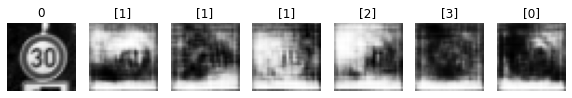

Epoch 871 g_loss= 1.2768506 d_loss= 0.53823954 real_acc= 0.72 fake_acc= 0.82
Epoch 872 g_loss= 1.1739943 d_loss= 0.515732 real_acc= 0.74 fake_acc= 0.76
Epoch 873 g_loss= 1.2589358 d_loss= 0.5077301 real_acc= 0.8 fake_acc= 0.76
Epoch 874 g_loss= 1.1859717 d_loss= 0.48300308 real_acc= 0.86 fake_acc= 0.76
Epoch 875 g_loss= 1.3208014 d_loss= 0.45788527 real_acc= 0.82 fake_acc= 0.8
Epoch 876 g_loss= 1.3902475 d_loss= 0.50981176 real_acc= 0.68 fake_acc= 0.78
Epoch 877 g_loss= 1.3745184 d_loss= 0.5185878 real_acc= 0.68 fake_acc= 0.92
Epoch 878 g_loss= 1.4847941 d_loss= 0.4161123 real_acc= 0.88 fake_acc= 0.84
Epoch 879 g_loss= 1.2743962 d_loss= 0.52022016 real_acc= 0.82 fake_acc= 0.82
Epoch 880 g_loss= 1.4009634 d_loss= 0.53169477 real_acc= 0.66 fake_acc= 0.96


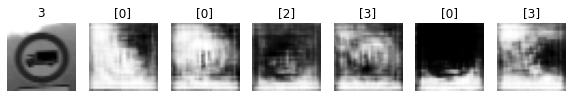

Epoch 881 g_loss= 1.5118717 d_loss= 0.41696328 real_acc= 0.78 fake_acc= 0.96
Epoch 882 g_loss= 1.5900738 d_loss= 0.4240194 real_acc= 0.7 fake_acc= 0.94
Epoch 883 g_loss= 1.321747 d_loss= 0.4572917 real_acc= 0.76 fake_acc= 0.84
Epoch 884 g_loss= 1.1579596 d_loss= 0.4872053 real_acc= 0.78 fake_acc= 0.78
Epoch 885 g_loss= 1.0839866 d_loss= 0.5562241 real_acc= 0.66 fake_acc= 0.78
Epoch 886 g_loss= 1.2525793 d_loss= 0.5069469 real_acc= 0.7 fake_acc= 0.8
Epoch 887 g_loss= 1.2022117 d_loss= 0.44604576 real_acc= 0.76 fake_acc= 0.88
Epoch 888 g_loss= 1.2155066 d_loss= 0.5586443 real_acc= 0.58 fake_acc= 0.8
Epoch 889 g_loss= 1.1832064 d_loss= 0.45231622 real_acc= 0.82 fake_acc= 0.74
Epoch 890 g_loss= 1.0952722 d_loss= 0.6074423 real_acc= 0.58 fake_acc= 0.76


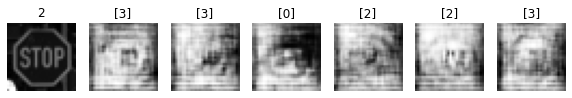

Epoch 891 g_loss= 1.1911529 d_loss= 0.60280323 real_acc= 0.52 fake_acc= 0.84
Epoch 892 g_loss= 0.9655873 d_loss= 0.6708493 real_acc= 0.58 fake_acc= 0.68
Epoch 893 g_loss= 0.9639996 d_loss= 0.62014234 real_acc= 0.66 fake_acc= 0.66
Epoch 894 g_loss= 1.011382 d_loss= 0.59499896 real_acc= 0.64 fake_acc= 0.7
Epoch 895 g_loss= 0.8736969 d_loss= 0.69159186 real_acc= 0.58 fake_acc= 0.64
Epoch 896 g_loss= 0.97201025 d_loss= 0.62095535 real_acc= 0.7 fake_acc= 0.66
Epoch 897 g_loss= 0.92611694 d_loss= 0.6304585 real_acc= 0.66 fake_acc= 0.6
Epoch 898 g_loss= 1.049823 d_loss= 0.6192812 real_acc= 0.64 fake_acc= 0.8
Epoch 899 g_loss= 1.0252694 d_loss= 0.708738 real_acc= 0.52 fake_acc= 0.64
Epoch 900 g_loss= 0.923988 d_loss= 0.7190267 real_acc= 0.62 fake_acc= 0.6


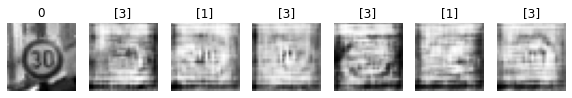

Epoch 901 g_loss= 1.0365784 d_loss= 0.7950053 real_acc= 0.5 fake_acc= 0.78
Epoch 902 g_loss= 0.9938179 d_loss= 0.7126128 real_acc= 0.6 fake_acc= 0.68
Epoch 903 g_loss= 0.9790052 d_loss= 0.76093173 real_acc= 0.54 fake_acc= 0.72
Epoch 904 g_loss= 1.0063484 d_loss= 0.8500751 real_acc= 0.48 fake_acc= 0.58
Epoch 905 g_loss= 0.8404012 d_loss= 0.73000777 real_acc= 0.6 fake_acc= 0.52
Epoch 906 g_loss= 0.81155133 d_loss= 0.7886134 real_acc= 0.58 fake_acc= 0.6
Epoch 907 g_loss= 0.8356422 d_loss= 0.76817715 real_acc= 0.54 fake_acc= 0.54
Epoch 908 g_loss= 0.6306456 d_loss= 0.7995723 real_acc= 0.6 fake_acc= 0.32
Epoch 909 g_loss= 0.7819443 d_loss= 0.7681273 real_acc= 0.5 fake_acc= 0.48
Epoch 910 g_loss= 0.7287808 d_loss= 0.8568144 real_acc= 0.46 fake_acc= 0.46


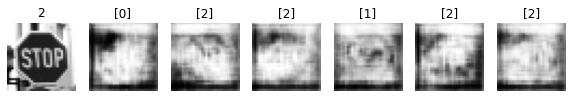

Epoch 911 g_loss= 0.7487851 d_loss= 0.7629837 real_acc= 0.48 fake_acc= 0.54
Epoch 912 g_loss= 0.7995911 d_loss= 0.7543812 real_acc= 0.54 fake_acc= 0.56
Epoch 913 g_loss= 0.92302287 d_loss= 0.7133509 real_acc= 0.6 fake_acc= 0.7
Epoch 914 g_loss= 0.7786239 d_loss= 0.8104539 real_acc= 0.54 fake_acc= 0.5
Epoch 915 g_loss= 0.9022531 d_loss= 0.72615814 real_acc= 0.5 fake_acc= 0.6
Epoch 916 g_loss= 0.7921875 d_loss= 0.71632504 real_acc= 0.62 fake_acc= 0.52
Epoch 917 g_loss= 0.88991743 d_loss= 0.7537998 real_acc= 0.52 fake_acc= 0.54
Epoch 918 g_loss= 0.83598816 d_loss= 0.6976923 real_acc= 0.58 fake_acc= 0.58
Epoch 919 g_loss= 0.79826605 d_loss= 0.7774751 real_acc= 0.52 fake_acc= 0.52
Epoch 920 g_loss= 0.74332994 d_loss= 0.7519731 real_acc= 0.56 fake_acc= 0.54


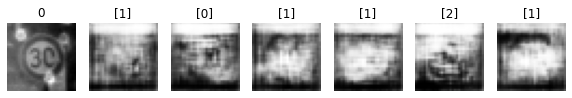

Epoch 921 g_loss= 0.7757468 d_loss= 0.7047783 real_acc= 0.54 fake_acc= 0.52
Epoch 922 g_loss= 0.74476904 d_loss= 0.676295 real_acc= 0.68 fake_acc= 0.5
Epoch 923 g_loss= 0.7676747 d_loss= 0.6567196 real_acc= 0.68 fake_acc= 0.52
Epoch 924 g_loss= 0.6125566 d_loss= 0.72431135 real_acc= 0.66 fake_acc= 0.34
Epoch 925 g_loss= 0.8098535 d_loss= 0.7284148 real_acc= 0.48 fake_acc= 0.6
Epoch 926 g_loss= 0.68136626 d_loss= 0.7163164 real_acc= 0.64 fake_acc= 0.38
Epoch 927 g_loss= 0.83521706 d_loss= 0.73334765 real_acc= 0.44 fake_acc= 0.52
Epoch 928 g_loss= 0.72584826 d_loss= 0.6963719 real_acc= 0.64 fake_acc= 0.36
Epoch 929 g_loss= 0.84923387 d_loss= 0.67893934 real_acc= 0.52 fake_acc= 0.54
Epoch 930 g_loss= 0.9051911 d_loss= 0.6458305 real_acc= 0.62 fake_acc= 0.66


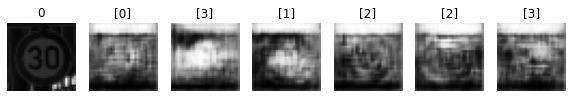

Epoch 931 g_loss= 0.8343291 d_loss= 0.6452131 real_acc= 0.6 fake_acc= 0.6
Epoch 932 g_loss= 0.8032121 d_loss= 0.6206862 real_acc= 0.66 fake_acc= 0.56
Epoch 933 g_loss= 0.8777106 d_loss= 0.61678576 real_acc= 0.66 fake_acc= 0.62
Epoch 934 g_loss= 0.8295286 d_loss= 0.6472435 real_acc= 0.7 fake_acc= 0.54
Epoch 935 g_loss= 0.85937166 d_loss= 0.66080725 real_acc= 0.58 fake_acc= 0.62
Epoch 936 g_loss= 0.8392658 d_loss= 0.5869832 real_acc= 0.68 fake_acc= 0.58
Epoch 937 g_loss= 0.8402426 d_loss= 0.5954392 real_acc= 0.72 fake_acc= 0.54
Epoch 938 g_loss= 0.7720471 d_loss= 0.60081744 real_acc= 0.8 fake_acc= 0.44
Epoch 939 g_loss= 0.88472396 d_loss= 0.558431 real_acc= 0.82 fake_acc= 0.6
Epoch 940 g_loss= 0.93384165 d_loss= 0.52007276 real_acc= 0.78 fake_acc= 0.64


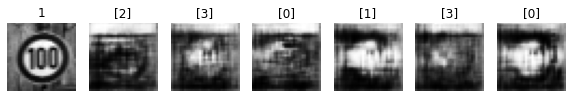

Epoch 941 g_loss= 0.93736327 d_loss= 0.5155444 real_acc= 0.78 fake_acc= 0.78
Epoch 942 g_loss= 0.8864117 d_loss= 0.5162571 real_acc= 0.88 fake_acc= 0.64
Epoch 943 g_loss= 0.90633464 d_loss= 0.5268234 real_acc= 0.88 fake_acc= 0.58
Epoch 944 g_loss= 0.956886 d_loss= 0.53371716 real_acc= 0.76 fake_acc= 0.82
Epoch 945 g_loss= 1.0243739 d_loss= 0.4773433 real_acc= 0.8 fake_acc= 0.88
Epoch 946 g_loss= 1.0228171 d_loss= 0.49597675 real_acc= 0.82 fake_acc= 0.88
Epoch 947 g_loss= 1.028161 d_loss= 0.46667686 real_acc= 0.88 fake_acc= 0.9
Epoch 948 g_loss= 1.0069159 d_loss= 0.5016548 real_acc= 0.76 fake_acc= 0.82
Epoch 949 g_loss= 1.0016484 d_loss= 0.48715603 real_acc= 0.92 fake_acc= 0.86
Epoch 950 g_loss= 0.9027829 d_loss= 0.5403459 real_acc= 0.76 fake_acc= 0.74


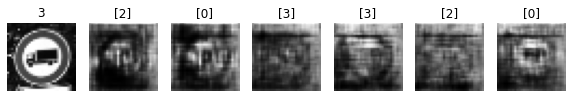

Epoch 951 g_loss= 0.9494882 d_loss= 0.50076175 real_acc= 0.94 fake_acc= 0.72
Epoch 952 g_loss= 0.81529176 d_loss= 0.5351759 real_acc= 0.9 fake_acc= 0.62
Epoch 953 g_loss= 0.75170904 d_loss= 0.5793029 real_acc= 0.9 fake_acc= 0.54
Epoch 954 g_loss= 0.75092214 d_loss= 0.5773493 real_acc= 0.88 fake_acc= 0.56
Epoch 955 g_loss= 0.69514054 d_loss= 0.61706126 real_acc= 0.82 fake_acc= 0.44
Epoch 956 g_loss= 0.72759604 d_loss= 0.62039286 real_acc= 0.78 fake_acc= 0.54
Epoch 957 g_loss= 0.68610907 d_loss= 0.68194056 real_acc= 0.74 fake_acc= 0.46
Epoch 958 g_loss= 0.71225 d_loss= 0.6867512 real_acc= 0.72 fake_acc= 0.46
Epoch 959 g_loss= 0.6886261 d_loss= 0.71577644 real_acc= 0.6 fake_acc= 0.48
Epoch 960 g_loss= 0.70272285 d_loss= 0.70888877 real_acc= 0.64 fake_acc= 0.5


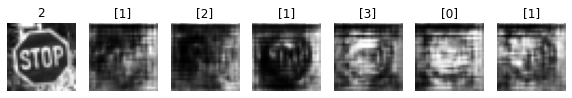

Epoch 961 g_loss= 0.67414767 d_loss= 0.7647257 real_acc= 0.42 fake_acc= 0.46
Epoch 962 g_loss= 0.6257109 d_loss= 0.7651701 real_acc= 0.58 fake_acc= 0.34
Epoch 963 g_loss= 0.60007155 d_loss= 0.76672006 real_acc= 0.54 fake_acc= 0.3
Epoch 964 g_loss= 0.5834089 d_loss= 0.7888384 real_acc= 0.54 fake_acc= 0.34
Epoch 965 g_loss= 0.57884735 d_loss= 0.76400554 real_acc= 0.58 fake_acc= 0.3
Epoch 966 g_loss= 0.5900952 d_loss= 0.7443739 real_acc= 0.64 fake_acc= 0.3
Epoch 967 g_loss= 0.5772781 d_loss= 0.79942656 real_acc= 0.58 fake_acc= 0.34
Epoch 968 g_loss= 0.5563883 d_loss= 0.82186234 real_acc= 0.38 fake_acc= 0.18
Epoch 969 g_loss= 0.548263 d_loss= 0.84757435 real_acc= 0.46 fake_acc= 0.2
Epoch 970 g_loss= 0.6041568 d_loss= 0.8224526 real_acc= 0.46 fake_acc= 0.3


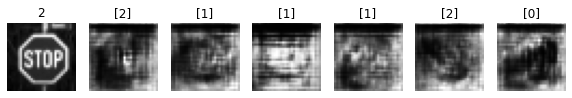

Epoch 971 g_loss= 0.6091627 d_loss= 0.8035644 real_acc= 0.48 fake_acc= 0.32
Epoch 972 g_loss= 0.61928076 d_loss= 0.7972013 real_acc= 0.4 fake_acc= 0.42
Epoch 973 g_loss= 0.634934 d_loss= 0.7521012 real_acc= 0.5 fake_acc= 0.4
Epoch 974 g_loss= 0.6284348 d_loss= 0.7974527 real_acc= 0.38 fake_acc= 0.38
Epoch 975 g_loss= 0.6007859 d_loss= 0.8135356 real_acc= 0.4 fake_acc= 0.34
Epoch 976 g_loss= 0.6183912 d_loss= 0.7738511 real_acc= 0.44 fake_acc= 0.38
Epoch 977 g_loss= 0.59827304 d_loss= 0.7743528 real_acc= 0.58 fake_acc= 0.3
Epoch 978 g_loss= 0.65847987 d_loss= 0.75812405 real_acc= 0.48 fake_acc= 0.46
Epoch 979 g_loss= 0.6774513 d_loss= 0.7629683 real_acc= 0.48 fake_acc= 0.44
Epoch 980 g_loss= 0.6415831 d_loss= 0.76913506 real_acc= 0.4 fake_acc= 0.38


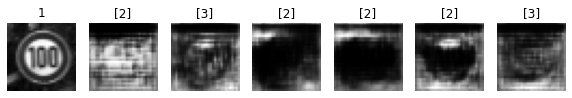

Epoch 981 g_loss= 0.6364338 d_loss= 0.7547452 real_acc= 0.5 fake_acc= 0.36
Epoch 982 g_loss= 0.65451235 d_loss= 0.7556753 real_acc= 0.54 fake_acc= 0.36
Epoch 983 g_loss= 0.7125816 d_loss= 0.75409603 real_acc= 0.44 fake_acc= 0.54
Epoch 984 g_loss= 0.73863554 d_loss= 0.71719563 real_acc= 0.54 fake_acc= 0.54
Epoch 985 g_loss= 0.68532157 d_loss= 0.7260555 real_acc= 0.6 fake_acc= 0.44
Epoch 986 g_loss= 0.741321 d_loss= 0.70809054 real_acc= 0.52 fake_acc= 0.52
Epoch 987 g_loss= 0.7182659 d_loss= 0.7084776 real_acc= 0.6 fake_acc= 0.42
Epoch 988 g_loss= 0.7532141 d_loss= 0.7016134 real_acc= 0.62 fake_acc= 0.5
Epoch 989 g_loss= 0.6942255 d_loss= 0.7282528 real_acc= 0.62 fake_acc= 0.42
Epoch 990 g_loss= 0.82375234 d_loss= 0.72554946 real_acc= 0.48 fake_acc= 0.5


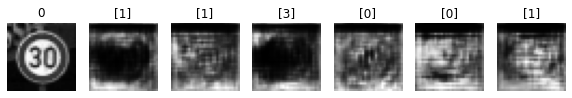

Epoch 991 g_loss= 0.79651064 d_loss= 0.66145635 real_acc= 0.66 fake_acc= 0.52
Epoch 992 g_loss= 0.7901582 d_loss= 0.70340323 real_acc= 0.56 fake_acc= 0.48
Epoch 993 g_loss= 0.84888196 d_loss= 0.6337014 real_acc= 0.68 fake_acc= 0.6
Epoch 994 g_loss= 0.8811398 d_loss= 0.6295203 real_acc= 0.68 fake_acc= 0.66
Epoch 995 g_loss= 0.85296386 d_loss= 0.6591896 real_acc= 0.68 fake_acc= 0.58
Epoch 996 g_loss= 0.8530339 d_loss= 0.6663087 real_acc= 0.66 fake_acc= 0.56
Epoch 997 g_loss= 0.90582323 d_loss= 0.6006098 real_acc= 0.8 fake_acc= 0.6
Epoch 998 g_loss= 0.8397392 d_loss= 0.65798295 real_acc= 0.7 fake_acc= 0.46
Epoch 999 g_loss= 0.9044937 d_loss= 0.6069603 real_acc= 0.72 fake_acc= 0.6
Done


In [14]:
epochs = 1000
history = []
for epoch in range(epochs):
    # take some random samples
    new_samples,new_labels = sample_from_dataset(50,samples)
    # perform one training step (epoch)
    do_step(new_samples, new_labels)
    
    if epoch % 10 == 0:
        # show one real image and some fake images generated by generator using noise seed
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        random_labels = np.random.randint(4, size=num_examples_to_generate)
        random_labels = np.expand_dims(random_labels,axis=1)
        predictions = generator([seed,random_labels], training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(samples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(samples[r, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.title(labels[r])
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.title("{}".format(random_labels[i]))
            plt.axis('off')
        plt.show()    
print("Done")

In [ ]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
plt.legend()
plt.show()

In [ ]:
nph = np.array(history)
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(nph[:,0], label='generator-loss')
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.plot(nph[:,1], label='discriminator-loss')
plt.legend()
plt.show()

In [ ]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.legend()
plt.show()

In [ ]:
###generator.save_weights('generator2_6000_weights')